In [1]:
import os,sys,re,time,math

from itertools import cycle


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from sklearn.externals import joblib

import matplotlib as mpl
import numpy as np
import pandas as pd

import sklearn
from matplotlib import pyplot as plt

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
 
#KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))


Using TensorFlow backend.


In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" #（其中0.1是选择所调用的gpu）

# gpu_options = tf.GPUOptions(allow_growth=True)

# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


#指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = tf.ConfigProto() 
#不全部占满显存, 按需分配
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

KTF.set_session(sess)


In [4]:


from keras import backend as K

from keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from keras.utils.np_utils import to_categorical

from keras.callbacks import ModelCheckpoint

In [5]:
def mean(a):
    return sum(a) / len(a)

In [6]:
def read_svm(file):
    encodings = []
    labels = []
    with open(file) as f:
        records = f.readlines()

    for line in records:
        line = re.sub('\d+:', '', line)
        array = line.strip().split() if line.strip() != '' else None
        encodings.append(array[1:])
        labels.append(int(array[0]))

    return np.array(encodings).astype(float), np.array(labels).astype(int)

In [7]:
def performance(labelArr, predictArr):
    #labelArr[i] is actual value,predictArr[i] is predict value
    TP = 0.; TN = 0.; FP = 0.; FN = 0.
    for i in range(len(labelArr)):
        if labelArr[i] == 1 and predictArr[i] == 1:
            TP += 1.
        if labelArr[i] == 1 and predictArr[i] == 0:
            FN += 1.
        if labelArr[i] == 0 and predictArr[i] == 1:
            FP += 1.
        if labelArr[i] == 0 and predictArr[i] == 0:
            TN += 1.
    if (TP + FN)==0:
        SN=0
    else:
        SN = TP/(TP + FN) #Sensitivity = TP/P  and P = TP + FN
    if (FP+TN)==0:
        SP=0
    else:
        SP = TN/(FP + TN) #Specificity = TN/N  and N = TN + FP
    if (TP+FP)==0:
        precision=0
    else:
        precision=TP/(TP+FP)
    if (TP+FN)==0:
        recall=0
    else:
        recall=TP/(TP+FN)
    GM=math.sqrt(recall*SP)
    #MCC = (TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    return precision,recall,SN,SP,GM,TP,TN,FP,FN

In [8]:
# ROC 图
def draw_ROC_curve(y_test,y_predict,savepath=None):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig(savepath)
    plt.close(0)

In [9]:
def plot_roc(y_pred, y_true, classes=None, title=None, savefile=None):
    """This function plot the ROC curve and return the AUC"""
    if len(y_pred.shape)==1:
        y_pred = y_pred.reshape(y_pred.shape+(1,))
        y_true = y_true.reshape(y_true.shape+(1,))
   
    n_classes = y_pred.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    if classes is None:
        legends = ['class'+str(j+1) for j in range(n_classes)]
    elif len(classes) == n_classes:
        legends = classes
    else:
        raise ValueError("Number of classes doesn't match labels")    
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    colors = cycle(['darkorange', 'cornflowerblue', 'navy', 'aqua'])    

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of {0} (area = {1:0.4f})'
                 ''.format(legends[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    else:
        plt.title('ROC curves for all classes')
    plt.legend(loc="lower right")
    if savefile:
        plt.savefig(savefile, dpi=300)
    return roc_auc_score

In [10]:
# 分割并序列编码
AA = 'GAVLIFWYDNEKQMSTCPHR'
def pep(path, seq_len):
    seqs = open(path).readlines()
    cut = (len(seqs[0].split()[0]) - 1 - seq_len) // 2
    X = [[AA.index(res.upper()) if res.upper() in AA else 0
          for res in (seq.split()[0][cut:-cut] if cut != 0 else seq.split()[0])]
        for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[-1]) for seq in seqs if seq.strip() != '']
    return np.array(X), np.array(y)

In [11]:
# precision-recall 图
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

In [12]:
# world embedding sliding windows
# keras 编码循环输出result
name = 'Embedding'
gap = ''
q = [21,23,25,27,29,31,35,37]
test_cutoff = [0.273422,0.268753,0.210156,0.272848,0.258505,0.300157,0.310499,0.201006]
train_cutoff = [0.26536,0.25023,0.203575,0.250609,0.235935,0.27466,0.287076,0.184949]

c = 0
for t in q :
    path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Train.txt'
    path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'

    x_train,y_train = pep(path_train,t-2)
    x_test,y_test = pep(path_test,t-2)

    
    path_train_result = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_keras_'+ str(t) + '_'+ name + gap+'_result.txt'
    path_test_result = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_keras_'+ str(t) + '_'+ name+ gap+'_result.txt'
    
    test_result = pd.read_table(path_test_result, header=None)

    train_result = pd.read_table(path_train_result, header=None)
    
    test_result_score = test_result[0]
    test_pred = np.array(test_result[1]) 
    
    train_result_score = train_result[0]
    train_pred = np.array(train_result[1])
    
    
    for i in range(0,len(test_result_score)):
        if test_result_score[i] > test_cutoff[c]:       
            test_pred[i] = 1
        else:
            test_pred[i] = 0
    fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
    print(t)
    print('test:')
    print("ACC:  %f "  %accuracy_score(y_test,test_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_test,test_result_score))
    precision, recall, thresholds = precision_recall_curve(y_test,test_result_score)
    draw_pr(precision, recall,savepath='C:/Users/Crow/Desktop/human_data_12.12/result/'+ name +'/pr/Test_keras_'+ str(t) + '_'+ name+ gap+'_result.png')
    
    
    for i in range(0,len(train_result_score)):
        if train_result_score[i] > train_cutoff[c]:       
            train_pred[i] = 1
        else:
            train_pred[i] = 0
    fpr, tpr, thresholds = roc_curve(y_train,train_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_train,train_pred)
    print(t)
    print('train:')
    print("ACC:  %f "  %accuracy_score(y_train,train_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_train,train_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_train,train_result_score))
    precision, recall, thresholds = precision_recall_curve(y_train,train_result_score)
    draw_pr(precision, recall,savepath='C:/Users/Crow/Desktop/human_data_12.12/result/'+ name +'/pr/Train_keras_'+ str(t) + '_'+ name+ gap+'_result.png')
    
    c+=1

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


21
test:
ACC:  0.867297 
Sn: 0.503034
Sp: 0.900042
MCC: 0.326328 
AUC: 0.845928
AUC: 0.845928


NameError: name 'draw_pr' is not defined

In [14]:
train_pred 

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [ ]:
draw_ROC_curve(y_test,test_result_score.values,'a')

In [ ]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)

In [39]:
precision

array([0.09990886, 0.09989691, 0.0998984 , ..., 1.        , 1.        ,
       1.        ])

In [ ]:
plot_pr_curve(precision,recall,'precision-recall')

In [ ]:
# ROC 01 图

In [16]:
data = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/Embedding/ROC/Test_keras_29_Embedding_ROC01_result.txt')

In [32]:
data2 = data[data['x-axie']<=0.1]

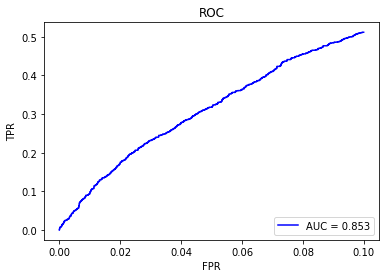

In [38]:

# false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
# roc_auc=auc(false_positive_rate, true_positive_rate)
plt.title('ROC')
plt.plot(data2['x-axie'], data2['y-axie'],'b',label='AUC = %0.3f'% 0.853252)
plt.legend(loc='lower right')
#plt.plot([0,0.1],[0,1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('c:/Users/Crow/Desktop/human_data_12.12/result/Embedding/ROC/Test_keras_29_Embedding_ROC01_result.png')
plt.close(0)

In [67]:
data2['y-axie'][0]

0.0

In [58]:
data2['y-axie'][2409]

KeyError: 2409

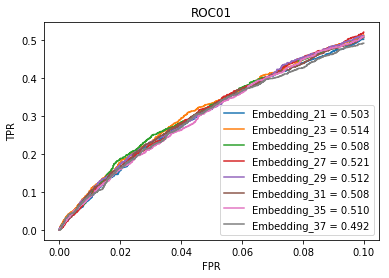

In [80]:
# 从文件夹读取ROC01result文本文档，生成ROC01图像

name = 'Embedding'
q = [21,23,25,27,29,31,35,37]
#q = [21,29]
for i in q:
    
    data = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/Embedding/ROC/Test_keras_'+ str(i) +'_Embedding_ROC01_result.txt')
    data2 = data[data['x-axie']<=0.1]
    plt.title('ROC01')
    plt.plot(data2['x-axie'], data2['y-axie'],label='Embedding_%d'%i + ' = %0.3f'%data2['y-axie'][len(data2)-1])
    plt.legend(loc='lower right')
    #plt.plot([0,0.1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig('c:/Users/Crow/Desktop/human_data_12.12/result/Embedding/ROC/Test_keras_Embedding_ROC01_result.png')
    plt.close(0)

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.


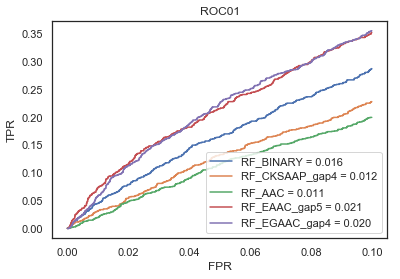

In [70]:
# ML-RF ROC01图
# 从文件夹读取ROC01result文本文档，生成ROC01图像
sns.set(style="white")
name = 'Embedding'
q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
q2=[0.0160313,0.0123301,0.0107476,0.0206107,0.0204529]
j=0
for i in q:
    
    data = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/RF_result/Test_29_'+ str(i) +'_ROC01_result.txt')
    data2 = data[data['x-axie']<=0.1]
    plt.title('ROC01')
    plt.plot(data2['x-axie'], data2['y-axie'],label='RF_%s'%i + ' = %0.3f'%q2[j])
    j +=1
    plt.legend(loc='lower right')
    #plt.plot([0,0.1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR') 
    plt.savefig('c:/Users/Crow/Desktop/result/picture/RF_result/Test_RF_ROC01_result_300.png',dpi=300)
    plt.close(0)

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


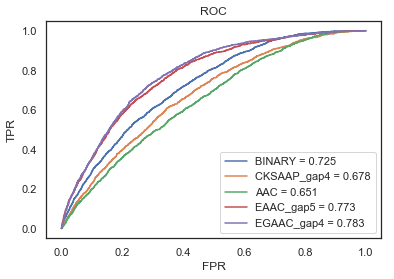

In [72]:
# ML-RF ROC图
# 从文件夹读取ROC01result文本文档，生成ROC图像

q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
q2=[0.725154,0.677986,0.65147,0.772582,0.78293]
j=0
for i in q:
    
    data = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/RF_result/Test_29_'+ str(i) +'_ROC01_result.txt')
    
    plt.title('ROC')
    plt.plot(data['x-axie'], data['y-axie'],label='%s'%i + ' = %0.3f'%q2[j])
    j+=1
    plt.legend(loc='lower right')
    #plt.plot([0,0.1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig('c:/Users/Crow/Desktop/result/picture/RF_result/Test_RF_ROC_result_300.png',dpi=300)
    plt.close(0)

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.


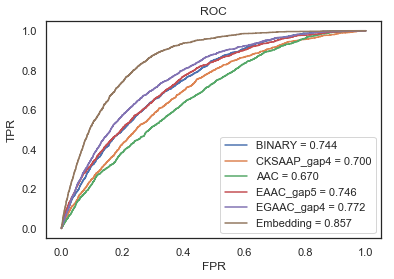

In [75]:
# DL-ALL ROC图
# 从文件夹读取ROC01result文本文档，生成ROC图像

q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4','Embedding']
q2=[0.744473,0.699561,0.669962,0.74616,0.771556,0.857359]
q3=[0.017798,0.0137952,0.0119581,0.0196674,0.0198363,0.030444]
j=0
for i in q:
    
    data = pd.read_table('c:/Users/Crow/Desktop/result/CNN_result/CNN_ROC01/29_kfold_CNN_'+ str(i) +'_ind_ROC01_result.txt')
     
    plt.title('ROC')
    plt.plot(data['x-axie'], data['y-axie'],label='%s'%i + ' = %0.3f'%q2[j])
    j+=1
    plt.legend(loc='lower right')
    #plt.plot([0,0.1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig('c:/Users/Crow/Desktop/result/picture/CNN_result/Test_DL_ROC_result_300.png',dpi=300)
    plt.close(0)

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # This is added back by InteractiveShellApp.init_path()


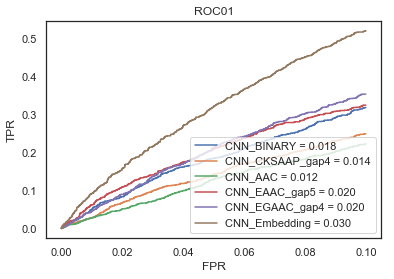

In [104]:
# DL-ALL ROC图
# 从文件夹读取ROC01result文本文档，生成ROC图像

q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4','Embedding']
q2=[0.744473,0.699561,0.669962,0.74616,0.771556,0.857359]
q3=[0.017798,0.0137952,0.0119581,0.0196674,0.0198363,0.030444]
j=0
for i in q:
    
    #data = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/DL_result/Test_keras_29_'+ str(i) +'_ROC01_result.txt')
    data = pd.read_table('C:/Users/Crow/Desktop/result/CNN_result/CNN_ROC01/29_kfold_CNN_'+ str(i) +'_ind_ROC01_result.txt')
     
    data2 = data[data['x-axie']<=0.1]
    plt.title('ROC01')
    plt.plot(data2['x-axie'], data2['y-axie'],label='CNN_%s'%i + ' = %0.3f'%q3[j])
    j+=1
    plt.legend(loc='lower right')
    #plt.plot([0,0.1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig('c:/Users/Crow/Desktop/result/picture/CNN_result/Test_DL_ROC01_result_300.png',dpi=300)
    plt.close(0)

In [ ]:
precision, recall, th = m.precision_recall_curve(y_true, y_pred)
ax = pl.subplot(2, 1, 2)
ax.plot(recall, precision)
ax.set_ylim([0.0, 1.0])
ax.set_title('Precision recall curve')

pl.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test,test_result_score)

In [ ]:
plot_pr_curve(precision,recall,'precision-recall')

In [ ]:
plt.figure(1) # 创建图表1
plt.title('Precision/Recall Curve')# give plot a title
plt.xlabel('Recall')# make axis labels
plt.ylabel('Precision')
 
#x、y都是列表，里面存的分别是recall和precision
#传参得到或读取文件得到无所谓
x=precision
y=recall
 
plt.figure(1)
plt.plot(x, y)
plt.show()
plt.savefig('p-r.png')



In [13]:
def draw_pr(precision,recall,savepath=None):
    plt.figure(0)
    plt.title('Precision/Recall Curve')# give plot a title
    plt.xlabel('Recall')# make axis labels
    plt.ylabel('Precision')
 
    plt.plot(precision, recall)
    plt.savefig(savepath)
    plt.close(0)
 

In [ ]:
draw_pr(precision, recall,savepath='C:/Users/Crow/Desktop/human_data_12.12/result/'+ name +'/pr/Train_keras_'+ str(t) + '_'+ name+ gap+'_result.png')

In [213]:
# ROC 与其他工具性能比较
# path = 'c:/Users/Crow/Desktop/CKSAAP_CrotSite/CKSAAP_CrotSite_15.csv'

# data = pd.read_csv(path)
# data = pd.read_table('c:/Users/Crow/Desktop/CKSAAP_CrotSite/CKSAAP_CrotSite_15.txt')

# data: 其他工具结果
data = pd.read_excel('C:/Users/Crow/Desktop/CKSAAP_CrotSite2/result_16.xlsx',names=['Protein ID','Lysine_position','Peptide','Crotonyllysine?','SVM_score'])
# 去除 \t
data['Peptide'] = [data['Peptide'][i].split('\t')[1] for i in range(0,len(data))]



data['Protein'] = [data['Protein ID'][i].split('_')[0] for i in range(0,len(data))]
data['Site'] = [data['Protein ID'][i].split('_')[1].split('|')[0] for i in range(0,len(data))]
data['Label'] = [0 if data['Crotonyllysine?'][i]==' No' else 1 for i in range(0,len(data))]

# 转换成数值类型
data['Site'] = pd.to_numeric(data['Site'])

data.head()




,Protein ID,Lysine_position,Peptide,Crotonyllysine?,SVM_score,Protein,Site,Label
0,A6NDG6_120|0|testing,16,TALYLRQRLAGAPAPKAYVLGSPALAAELEA,No,-0.7827,A6NDG6,120,0
1,A6NDG6_180|0|testing,16,VRAVVVGFDPHFSYMKLTKALRYLQQPGCLL,No,-0.7996,A6NDG6,180,0
2,A6NDG6_183|0|testing,16,VVVGFDPHFSYMKLTKALRYLQQPGCLLVGT,No,-0.7902,A6NDG6,183,0
3,A6NDG6_235|0|testing,16,RAVEMAAQRQADIIGKPSRFIFDCVSQEYGI,No,-0.8190,A6NDG6,235,0
4,A6NDG6_275|0|testing,16,DRLDTDILLGATCGLKTILTLTGVSTLGDVK,No,-0.8093,A6NDG6,275,0


In [215]:
len(data)

17480

In [216]:
path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'
# data2: 独立测试集
# x_test,y_test = pep(path_test,27)
data2 = pd.read_table(path_test,names=['Peptide','Protein','Site','Label'])
data2.head()


,Peptide,Protein,Site,Label
0,ALRARGKRLGFITNNSSKTRAAYAEKLRRLGFGGPAGPGASLEVFG...,A6NDG6,80,1
1,KKSTRKSPTFRNRPDFRKNKGRQLNKTTKQKK--------------...,A6NEN9,177,1
2,AVGQLEHFRSQVIKATYGRAKPFRDKPVTDQQLIEKITQVTEDNIN...,B1AJZ9,513,1
3,GHALKPQVSSIFTSFLDGLKKFYITKFKGFDPNQLSVATLLFEGDR...,O00116,454,1
4,YITKFKGFDPNQLSVATLLFEGDREKVLQHEKQVYDIAAKFGGLAA...,O00116,476,1


In [217]:
# 按照顺序重新排列以加快匹配速度
data = data.sort_values(['Protein','Site'])
data2 = data2.sort_values(['Protein','Site'])


In [218]:
data.head(30)

,Protein ID,Lysine_position,Peptide,Crotonyllysine?,SVM_score,Protein,Site,Label
9,A6NDG6_61|0|testing,16,VPGAPEALRALRARGKRLGFITNNSSKTRAA,No,-0.8226,A6NDG6,61,0
10,A6NDG6_72|0|testing,16,RARGKRLGFITNNSSKTRAAYAEKLRRLGFG,No,-0.8368,A6NDG6,72,0
11,A6NDG6_80|1|testing,16,FITNNSSKTRAAYAEKLRRLGFGGPAGPGAS,No,-0.8512,A6NDG6,80,0
0,A6NDG6_120|0|testing,16,TALYLRQRLAGAPAPKAYVLGSPALAAELEA,No,-0.7827,A6NDG6,120,0
1,A6NDG6_180|0|testing,16,VRAVVVGFDPHFSYMKLTKALRYLQQPGCLL,No,-0.7996,A6NDG6,180,0
2,A6NDG6_183|0|testing,16,VVVGFDPHFSYMKLTKALRYLQQPGCLLVGT,No,-0.7902,A6NDG6,183,0
3,A6NDG6_235|0|testing,16,RAVEMAAQRQADIIGKPSRFIFDCVSQEYGI,No,-0.8190,A6NDG6,235,0
4,A6NDG6_275|0|testing,16,DRLDTDILLGATCGLKTILTLTGVSTLGDVK,No,-0.8093,A6NDG6,275,0
5,A6NDG6_290|0|testing,16,KTILTLTGVSTLGDVKNNQESDCVSKKKMVP,No,-0.8011,A6NDG6,290,0
6,A6NDG6_300|0|testing,16,TLGDVKNNQESDCVSKKKMVPDFYVDSIADL,No,-0.7901,A6NDG6,300,0


In [219]:
data2.head(30)

,Peptide,Protein,Site,Label
1483,DGVLWRGETAVPGAPEALRALRARGKRLGFITNNSSKTRAAYAEKL...,A6NDG6,61,0
1484,PGAPEALRALRARGKRLGFITNNSSKTRAAYAEKLRRLGFGGPAGP...,A6NDG6,72,0
0,ALRARGKRLGFITNNSSKTRAAYAEKLRRLGFGGPAGPGASLEVFG...,A6NDG6,80,1
1485,SLEVFGTAYCTALYLRQRLAGAPAPKAYVLGSPALAAELEAVGVAS...,A6NDG6,120,0
1486,DWLHAPLEPDVRAVVVGFDPHFSYMKLTKALRYLQQPGCLLVGTNM...,A6NDG6,180,0
1487,HAPLEPDVRAVVVGFDPHFSYMKLTKALRYLQQPGCLLVGTNMDNR...,A6NDG6,183,0
1488,RFIAGTGCLVRAVEMAAQRQADIIGKPSRFIFDCVSQEYGINPERT...,A6NDG6,235,0
1489,INPERTVMVGDRLDTDILLGATCGLKTILTLTGVSTLGDVKNNQES...,A6NDG6,275,0
1490,DILLGATCGLKTILTLTGVSTLGDVKNNQESDCVSKKKMVPDFYVD...,A6NDG6,290,0
1491,KTILTLTGVSTLGDVKNNQESDCVSKKKMVPDFYVDSIADLLPALQ...,A6NDG6,300,0


In [ ]:
# data 原始数据存在数据重复现象 预测网站生成的数据问题
# 解决方案1:去除重复行，会有数据行数缺损，无法完全匹配，在data2种去除缺损数据行
# Excel完成删除重复项

# odata.drop(odata.index[[16,17]],inplace=True)

data.drop()


In [230]:
# 初始化
data['Label_true'] = None
data.head()

,Protein ID,Lysine_position,Peptide,Crotonyllysine?,SVM_score,Protein,Site,Label,Label_true
9,A6NDG6_61|0|testing,16,VPGAPEALRALRARGKRLGFITNNSSKTRAA,No,-0.8226,A6NDG6,61,0,None
10,A6NDG6_72|0|testing,16,RARGKRLGFITNNSSKTRAAYAEKLRRLGFG,No,-0.8368,A6NDG6,72,0,None
11,A6NDG6_80|1|testing,16,FITNNSSKTRAAYAEKLRRLGFGGPAGPGAS,No,-0.8512,A6NDG6,80,0,None
0,A6NDG6_120|0|testing,16,TALYLRQRLAGAPAPKAYVLGSPALAAELEA,No,-0.7827,A6NDG6,120,0,None
1,A6NDG6_180|0|testing,16,VRAVVVGFDPHFSYMKLTKALRYLQQPGCLL,No,-0.7996,A6NDG6,180,0,None


In [231]:
# 匹配 预测与实际:

for i in range(0,len(data)):
    for j in range(0,len(data2)):
        if data['Protein'][i]==data2['Protein'][j] and data['Site'][i]==data2['Site'][j]:
            data['Label_true'][i] = data2['Label'][j]

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [263]:
data.head(100)

,Protein ID,Lysine_position,Peptide,Crotonyllysine?,SVM_score,Protein,Site,Label,Label_true
9,A6NDG6_61|0|testing,16,VPGAPEALRALRARGKRLGFITNNSSKTRAA,No,-0.8226,A6NDG6,61,0,0
10,A6NDG6_72|0|testing,16,RARGKRLGFITNNSSKTRAAYAEKLRRLGFG,No,-0.8368,A6NDG6,72,0,0
11,A6NDG6_80|1|testing,16,FITNNSSKTRAAYAEKLRRLGFGGPAGPGAS,No,-0.8512,A6NDG6,80,0,1
0,A6NDG6_120|0|testing,16,TALYLRQRLAGAPAPKAYVLGSPALAAELEA,No,-0.7827,A6NDG6,120,0,0
1,A6NDG6_180|0|testing,16,VRAVVVGFDPHFSYMKLTKALRYLQQPGCLL,No,-0.7996,A6NDG6,180,0,0
2,A6NDG6_183|0|testing,16,VVVGFDPHFSYMKLTKALRYLQQPGCLLVGT,No,-0.7902,A6NDG6,183,0,0
3,A6NDG6_235|0|testing,16,RAVEMAAQRQADIIGKPSRFIFDCVSQEYGI,No,-0.8190,A6NDG6,235,0,0
4,A6NDG6_275|0|testing,16,DRLDTDILLGATCGLKTILTLTGVSTLGDVK,No,-0.8093,A6NDG6,275,0,0
5,A6NDG6_290|0|testing,16,KTILTLTGVSTLGDVKNNQESDCVSKKKMVP,No,-0.8011,A6NDG6,290,0,0
6,A6NDG6_300|0|testing,16,TLGDVKNNQESDCVSKKKMVPDFYVDSIADL,No,-0.7901,A6NDG6,300,0,0


In [253]:
y_test = list(data['Label_true'])
pre2 = list(data['Label'])
pre_score = list(data['SVM_score'])

In [271]:
type(pre_score[0])

float

In [264]:
fpr, tpr, thresholds = roc_curve(y_test,pre_score)

print(sklearn.metrics.auc(fpr, tpr))

0.4641598974790915


In [266]:
#sklearn.metrics.roc_curve(y_test,pre2)
sklearn.metrics.roc_auc_score(y_test,pre_score)

0.4641598974790915

In [274]:
fw = open('C:/Users/Crow/Desktop/result/CKSAAP_sites_result.txt','w')
for i in range(0,len(pre_score)):
    fw.write(str(pre_score[i]))
    fw.write('\t')
    fw.write(str(y_test[i]))
    fw.write('\n')
fw.close()

In [258]:
# 确认 CKSAAP_CrotSite 工具的准确度






fpr, tpr, thresholds = roc_curve(y_test,pre_score,pos_label=1)
print(sklearn.metrics.auc(fpr, tpr))
_,_,SN,SP,_,_,_,_,_ = performance(y_test,pre2)
print("ACC:  %f "  %accuracy_score(y_test,pre2))
print("Sn: %f" %SN) 
print("Sp: %f" %SP)
print("MCC: %f " %matthews_corrcoef(y_test,pre2))
print("AUC: %f" % auc(fpr, tpr))


0.4641598974790915
ACC:  0.914874 
Sn: 0.000674
Sp: 0.999625
MCC: 0.004167 
AUC: 0.464160


In [220]:
data2['pre_label'] = [data['Label'][i] for i in range(0,len(data)) for j in range(0,len(data2)) if data['Protein'][i]==data2['Protein'][j]and data['Site'][i]==data2['Site'][j]]

ValueError: Length of values does not match length of index

In [88]:
for j in range(0,len(data2)):
    for i in range(0,len(data)):
        if data['Protein'][i]==data2['Protein'][j] and data['Site'][i]==data2['Site'][j]:
            data2['pre_label'][j] = data['Label'][i]

In [87]:
  for j in range(0,len(data2)):
    for i in range(0,len(data)):
        if data['Protein'][i]==data2['Protein'][j] and data['Site'][i]==data2['Site'][j]:
            print("h") 

In [ ]:
for i in range(0,len(data)):
    for j in range(0,len(data2))

In [ ]:
data2['Site'][j]

In [86]:
data2.head()

,Peptide,Protein,Site,Label
0,ALRARGKRLGFITNNSSKTRAAYAEKLRRLGFGGPAGPGASLEVFG...,A6NDG6,80,1
1,KKSTRKSPTFRNRPDFRKNKGRQLNKTTKQKK--------------...,A6NEN9,177,1
2,AVGQLEHFRSQVIKATYGRAKPFRDKPVTDQQLIEKITQVTEDNIN...,B1AJZ9,513,1
3,GHALKPQVSSIFTSFLDGLKKFYITKFKGFDPNQLSVATLLFEGDR...,O00116,454,1
4,YITKFKGFDPNQLSVATLLFEGDREKVLQHEKQVYDIAAKFGGLAA...,O00116,476,1


In [ ]:
roc_curve(data2['Label'],data2['pre_label'])

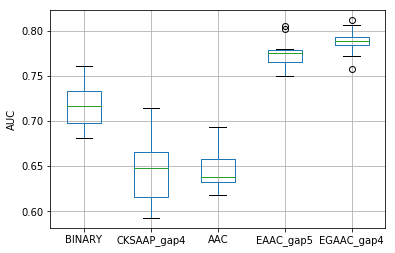

In [368]:
# 箱线图
# 10-StratifiedKFold
# RF-ALL ROC图

q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
q2=[0.741638,0.692215,0.669857,0.739323,0.77166,0.853252]
q3=[0.0168049,0.0129586,0.0118679,0.0186706,0.0196938,0.0307755]
# 十折交叉检验后的AUC AUC01


# BINARY = [0.811513,0.771521,0.788787,0.787945,0.757533,0.783576,0.785209,0.790319,0.805895,0.793693]
# BINARY_01 = [ 0.0237978,0.0222465,0.02031,0.0236174,0.0165625, 0.0201013,0.0188091, 0.0210482, 0.023615,0.0228948]
BINARY = [0.761391,0.700537,0.697019,0.712532,0.681142,0.680617,0.722501,0.736251,0.760365,0.720973]
BINARY_01 = [0.0187068,0.0158709,0.0146236,0.0157431,0.0103937,0.0131881,0.0151615,0.0179435,0.0213186,0.0170614]

# CKSAAP_gap4 = [0.667223,0.647159,0.646928,0.604349, 0.592533,0.605498,0.7142, 0.648248,0.672056, 0.659887]
# CKSAAP_gap4_01 = [0.011353, 0.00953636,0.00760102, 0.00843605, 0.00224004, 0.00598553,0.0141972,0.0119433, 0.0123567, 0.0129452]
CKSAAP_gap4 = [0.667223,0.647159,0.646928,0.604349,0.592533,0.605498,0.7142,0.648248,0.672056,0.659887]
CKSAAP_gap4_01 = [0.011353,0.00953636,0.00760102,0.00843605,0.00224004,0.00598553,0.0141972,0.0119433,0.0123567,0.0129452]


# AAC = [0.661192,0.634855,0.648953,0.6363,0.618314,0.631479,0.693027,0.622349,0.663004,0.638802]
# AAC_01 =[0.010679,0.0100116,0.00958302,0.00920025,0.00647109,0.00673615,0.0133467,0.00978921,0.00953388,0.0109846]
AAC = [0.661192,0.634855,0.648953,0.6363,0.618314,0.631479,0.693027,0.622349,0.663004,0.638802]
AAC_01 = [0.010679,0.0100116,0.00958302,0.00920025,0.00647109,0.00673615,0.0133467,0.00978921,0.00953388,0.0109846]
    
# EAAC_gap5 = [0.804696,0.764802,0.778799,0.775034,0.750161,0.749447,0.779259,0.766585,0.801942,0.775]
# EAAC_gap5_01 =[0.0247101,0.021117,0.0211208,0.0223418,0.0148089,0.018484,0.0183516,0.0190385,0.024318,0.0224604]
EAAC_gap5 = [0.804696,0.764802,0.778799,0.775034,0.750161,0.749447,0.779259,0.766585,0.801942,0.775]
EAAC_gap5_01 = [0.0247101,0.0211179,0.0211208,0.0223418,0.0148089,0.018484,0.0183516,0.0190385,0.024318,0.0224604]    
    
    
# EGAAC_gap4 = [0.811513,0.771521,0.788787,0.787945,0.757533,0.783576,0.785209,0.790319,0.805895,0.793693]
# EGAAC_gap4_01 = [ 0.0237978,0.0222465,0.02031,0.0236174,0.0165625,0.0201013,0.0188091,0.0210482,0.023615,0.0228948]
EGAAC_gap4 = [0.811513,0.771521,0.788787,0.787945,0.757533,0.783576,0.785209,0.790319,0.805895,0.793693]
EGAAC_gap4_01 = [0.0247101,0.0211179,0.0211208,0.0223418,0.0148089,0.018484,0.0183516,0.0190385,0.024318,0.0224604]


AUC_data ={
    'BINARY':BINARY,
    'CKSAAP_gap4':CKSAAP_gap4,
    'AAC':AAC,
    'EAAC_gap5':EAAC_gap5,
    'EGAAC_gap4':EGAAC_gap4
} 

df = pd.DataFrame(AUC_data )



columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
plt.ylabel('AUC')
df.boxplot() #也可用plot.box()
plt.show()

In [382]:
AUC_p_value = [2.767986178197107e-05,0.8888692886539616,1.847463552061973e-09,0.0021307198823327035]
AUC_01_p_value = [1.0763135088546872e-05,0.9701761834482167,7.301964804674571e-07]
print(ttest_rel(EAAC_gap5_01,EGAAC_gap4_01))

Ttest_relResult(statistic=nan, pvalue=nan)


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


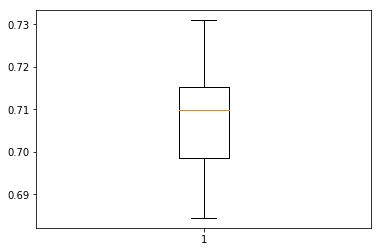

In [397]:
a = [0.708074,0.68444,0.711581,0.716382,0.71162,0.696588,0.704422,0.723463,0.730921,0.687607]
plt.boxplot(a) #也可用plot.box()
plt.show()

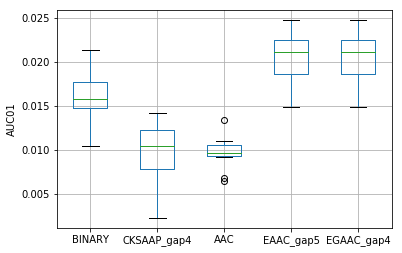

In [369]:

AUC01_data ={
    'BINARY':BINARY_01,
    'CKSAAP_gap4':CKSAAP_gap4_01,
    'AAC':AAC_01,
    'EAAC_gap5':EAAC_gap5_01,
    'EGAAC_gap4':EGAAC_gap4_01
} 

df = pd.DataFrame(AUC01_data)



columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
plt.ylabel('AUC01')
df.boxplot() #也可用plot.box()
plt.show()

In [20]:
# 配对样本t检验

from  scipy.stats import ttest_rel

print(ttest_rel(BINARY, CKSAAP_gap4))

NameError: name 'BINARY' is not defined

In [12]:
# 临时在此  
# 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import cluster
def read_svm(file):
    encodings = []
    labels = []
    with open(file) as f:
        records = f.readlines()

    for line in records:
        line = re.sub('\d+:', '', line)
        array = line.strip().split() if line.strip() != '' else None
        encodings.append(array[1:])
        labels.append(int(array[0]))

    return np.array(encodings).astype(float), np.array(labels).astype(int)

In [19]:
# 临时在此


name = 'EGAAC'
gap = '_gap4'
# 读取数据


path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]



kf = StratifiedKFold(n_splits = 10)
j=1
for train_index, test_index in kf.split(x_train, y_train):

    x_train3, x_test3 = x_train[train_index], x_train[test_index]
    y_train3, y_test3 = y_train[train_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=2,
                                 random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)
    clf.fit(x_train3, y_train3)
    test_pred = clf.predict(x_test3)
    test_pred_proba = clf.predict_proba(x_test3)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test3,test_pred_proba,pos_label=1)
    #print("ACC:  %f "  %accuracy_score(y_test3,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    #print("MCC: %f " %matthews_corrcoef(y_test3,test_pred))
    fw = open('C:/Users/Crow/Desktop/result/29_'+ name + gap +'_result_'+ str(j) +'.txt','w')
    
    for t in range(0,len(test_pred_proba)):
        fw.write(str(test_pred_proba[t]))
        fw.write('\t')
        fw.write(str(y_test3[t]))
        fw.write('\n')
    fw.close()
    
      
    
    if j == 10:
        joblib.dump(clf, 'C:/Users/Crow/Desktop/result/model/clf_'+ name + gap +'.pkl')
        
        test_pred_proba = clf.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
        print("总AUC: %f" % auc(fpr, tpr))
        fw = open('C:/Users/Crow/Desktop/result/29_'+ name + gap +'_result.txt','w')
        for t in range(0,len(test_pred_proba)):
            fw.write(str(test_pred_proba[t]))
            fw.write('\t')
            fw.write(str(y_test[t]))
            fw.write('\n')
        fw.close()
    j+=1
        

AUC: 0.811513
AUC: 0.771521
AUC: 0.788787
AUC: 0.787945
AUC: 0.757533
AUC: 0.783576
AUC: 0.785209
AUC: 0.790319
AUC: 0.805895
AUC: 0.793693
总AUC: 0.783190


In [17]:
# 临时在此
# RF 10-KFold

# RF 10-KFold
# 重新计算，单独输出各个k的predict结果，取平均值，选出最优模型

name = 'EAAC'
gap = '_gap5'
# 读取数据


path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]



kf = KFold(n_splits = 10,random_state=5,shuffle=True)
j = 1
auc_mean = []
for train_index, test_index in kf.split(x_train):
    x_train3, x_test3 = x_train[train_index], x_train[test_index]
    y_train3, y_test3 = y_train[train_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=3,
                                 random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)
    clf.fit(x_train3, y_train3)
    test_pred = clf.predict(x_test3)
    test_pred_proba = clf.predict_proba(x_test3)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test3,test_pred_proba,pos_label=1)
    #print("ACC:  %f "  %accuracy_score(y_test3,test_pred))
    print("AUC: %f" % auc(fpr, tpr))

    auc_mean.append(auc(fpr, tpr))
    #print("MCC: %f " %matthews_corrcoef(y_test3,test_pred))
    joblib.dump(clf, 'C:/Users/Crow/Desktop/new_result/model/'+ str(j) +'_clf_kfold_'+ name + gap +'.pkl')
    fw = open('C:/Users/Crow/Desktop/new_result/29_kfold_'+ name + gap+'_result_'+ str(j) +'.txt','w')
   
    for t in range(0,len(test_pred_proba)):
        fw.write(str(test_pred_proba[t]))
        fw.write('\t')
        fw.write(str(y_test3[t]))
        fw.write('\n')
    fw.close()

    
    if j == 10:        
        print(auc_mean)
        print(print("CV AUC: %f" % mean(auc_mean)))
        
    j+=1
    
    

AUC: 0.781925
AUC: 0.778667
AUC: 0.785795
AUC: 0.799003
AUC: 0.797184
AUC: 0.770403
AUC: 0.794130
AUC: 0.795108
AUC: 0.792157
AUC: 0.763667
[0.7819248451179182, 0.7786667939932754, 0.7857946482194096, 0.7990030668277178, 0.7971836721622502, 0.770402605530084, 0.7941303486460466, 0.7951077299592624, 0.7921574744667679, 0.7636671678276657]
CV AUC: 0.785804
None


In [18]:
# 临时在此
# RF 10-KFold

# RF 10-KFold
# 重新计算，单独输出各个k的predict结果，取平均值，选出最优模型

name = 'AAC'
gap = ''
# 读取数据


path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]



kf = KFold(n_splits = 10,random_state=5,shuffle=True)
j = 1
auc_mean = []
for train_index, test_index in kf.split(x_train):
    x_train3, x_test3 = x_train[train_index], x_train[test_index]
    y_train3, y_test3 = y_train[train_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators=1600,oob_score=True,n_jobs=3,
                                 random_state=50,max_depth=11,min_samples_split=30,max_features=19,min_samples_leaf=20)
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=4,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)
    clf.fit(x_train3, y_train3)
    test_pred = clf.predict(x_test3)
    test_pred_proba = clf.predict_proba(x_test3)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test3,test_pred_proba,pos_label=1)
    #print("ACC:  %f "  %accuracy_score(y_test3,test_pred))
    print("AUC: %f" % auc(fpr, tpr))

    auc_mean.append(auc(fpr, tpr))
    #print("MCC: %f " %matthews_corrcoef(y_test3,test_pred))
    joblib.dump(clf, 'C:/Users/Crow/Desktop/new_result/model/'+ str(j) +'_clf_kfold_'+ name + gap +'.pkl')
    fw = open('C:/Users/Crow/Desktop/new_result/29_kfold_'+ name + gap+'_result_'+ str(j) +'.txt','w')
   
    for t in range(0,len(test_pred_proba)):
        fw.write(str(test_pred_proba[t]))
        fw.write('\t')
        fw.write(str(y_test3[t]))
        fw.write('\n')
    fw.close()

    
    if j == 10:        
        print(auc_mean)
        print(print("CV AUC: %f" % mean(auc_mean)))
        
    j+=1

AUC: 0.690762
AUC: 0.668639
AUC: 0.696056
AUC: 0.692778
AUC: 0.680706
AUC: 0.672314
AUC: 0.685876
AUC: 0.699649
AUC: 0.695781
AUC: 0.658347
[0.6907617000279919, 0.6686386987343016, 0.6960564539448806, 0.6927777492225848, 0.6807063994349773, 0.6723144955372066, 0.6858764202521264, 0.6996494931591422, 0.6957805190091684, 0.6583465324876301]
CV AUC: 0.684091
None


In [15]:
print(auc_mean)
print(print("CV AUC: %f" % mean(auc_mean)))

[0.7837409269886865, 0.7899161457868245, 0.7934332806904375, 0.8028734376740083, 0.7968480601582894, 0.7801319594492998, 0.7996973112094343, 0.7816842473286023, 0.8076622075371946, 0.7751089079811924]
CV AUC: 0.791110
None


In [45]:
# 读取文档 获得 AUC
name='Embedding'
gap=''
a = []
b = []
for i in range(1,11):
    path = 'C:/Users/Crow/Desktop/result/kfold_result/29_kfold_CNN_'+name+gap+'_result_'+str(i)+'_ROC01_result.txt'
    fr = open(path,'r')
    for line in fr.readlines()[0:1]:
        print(line.split(':')[1].split('\n')[0])
        a.append(float(line.split(':')[1].split('\n')[0]))
        print(',')
    fr.close()
    fr = open(path,'r')
    for line in fr.readlines()[1:2]:
        print(line.split(':')[1].split('\n')[0])
        b.append(float(line.split(':')[1].split('\n')[0]))
        print(',')
    fr.close()
    #print('\n')

 0.854307
,
 0.0302004
,
 0.850165
,
 0.0304466
,
 0.855998
,
 0.033405
,
 0.869378
,
 0.0348931
,
 0.863474
,
 0.0315187
,
 0.848972
,
 0.0302907
,
 0.858895
,
 0.0319394
,
 0.86415
,
 0.0327611
,
 0.865656
,
 0.0330019
,
 0.848028
,
 0.0298258
,


In [47]:
b

[0.0302004,
 0.0304466,
 0.033405,
 0.0348931,
 0.0315187,
 0.0302907,
 0.0319394,
 0.0327611,
 0.0330019,
 0.0298258]

In [ ]:
# CNN 10-fold 后数据
# CNN 画箱线图 和 配对t-test
BINARY = [0.74858,0.72531,0.729377,0.746291,0.757209,0.716943,0.740705,0.748711,0.742049,0.718348]
BINARY_01 = [0.0193452,0.0188348,0.0163788,0.0192694,0.0200857,0.015796,0.019242,0.0188909,0.0187123,0.0156583]

CKSAAP = [0.727375,0.702889,0.718538,0.715293,0.720199,0.705757,0.71776,0.733371,0.732077,0.708407]
CKSAAP_01 = [0.0184811,0.0164841,0.0182857,0.0167354,0.0165019,0.017638,0.0175967,0.0206279,0.0198656,0.0172003]

AAC = [0.697583,0.679292,0.687933,0.705022,0.684746,0.674327,0.679923,0.691915,0.704359,0.667148]
AAC_01 = [0.0133235,0.0137827,0.0143659,0.0125646,0.013833,0.0137815,0.0134525,0.0149948,0.0136725,0.0121731]

EAAC = [0.758458,0.733854,0.751117,0.765943,0.772624,0.727126,0.756891,0.772324,0.767318,0.738252]
EAAC_gap5 = [0.0230343,0.0199245,0.0208168,0.0205771,0.0221402,0.0196654,0.019176,0.0217752,0.0213537,0.0189261]

EGAAC = [0.780899,0.777842,0.769064,0.785129,0.782205,0.775279,0.790265,0.76701,0.802266,0.765053]
EGAAC_gap4 = [0.0228899,0.0214292,0.0222644,0.0208791,0.0235234,0.020972,0.0223185,0.0208777,0.0250482,0.0191102]

Embedding = [0.854307,0.850165,0.855998,0.869378,0.863474,0.848972,0.858895,0.86415,0.865656,0.848028]
Embedding_01 = [0.0302004,0.0304466,0.033405,0.0348931,0.0315187,0.0302907,0.0319394,0.0327611,0.0330019,0.0298258]

AUC_data ={
    'BINARY':BINARY,
    'CKSAAP_gap4':CKSAAP_gap4,
    'AAC':AAC,
    'EAAC_gap5':EAAC_gap5,
    'EGAAC_gap4':EGAAC_gap4,
    'Embedding':Embedding
} 


AUC01_data ={
    'BINARY':BINARY_01,
    'CKSAAP_gap4':CKSAAP_gap4_01,
    'AAC':AAC_01,
    'EAAC_gap5':EAAC_gap5_01,
    'EGAAC_gap4':EGAAC_gap4_01,
    'Embedding':Embedding_01
}

df = pd.DataFrame(AUC_data)
df_01 = pd.DataFrame(AUC01_data)


columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']



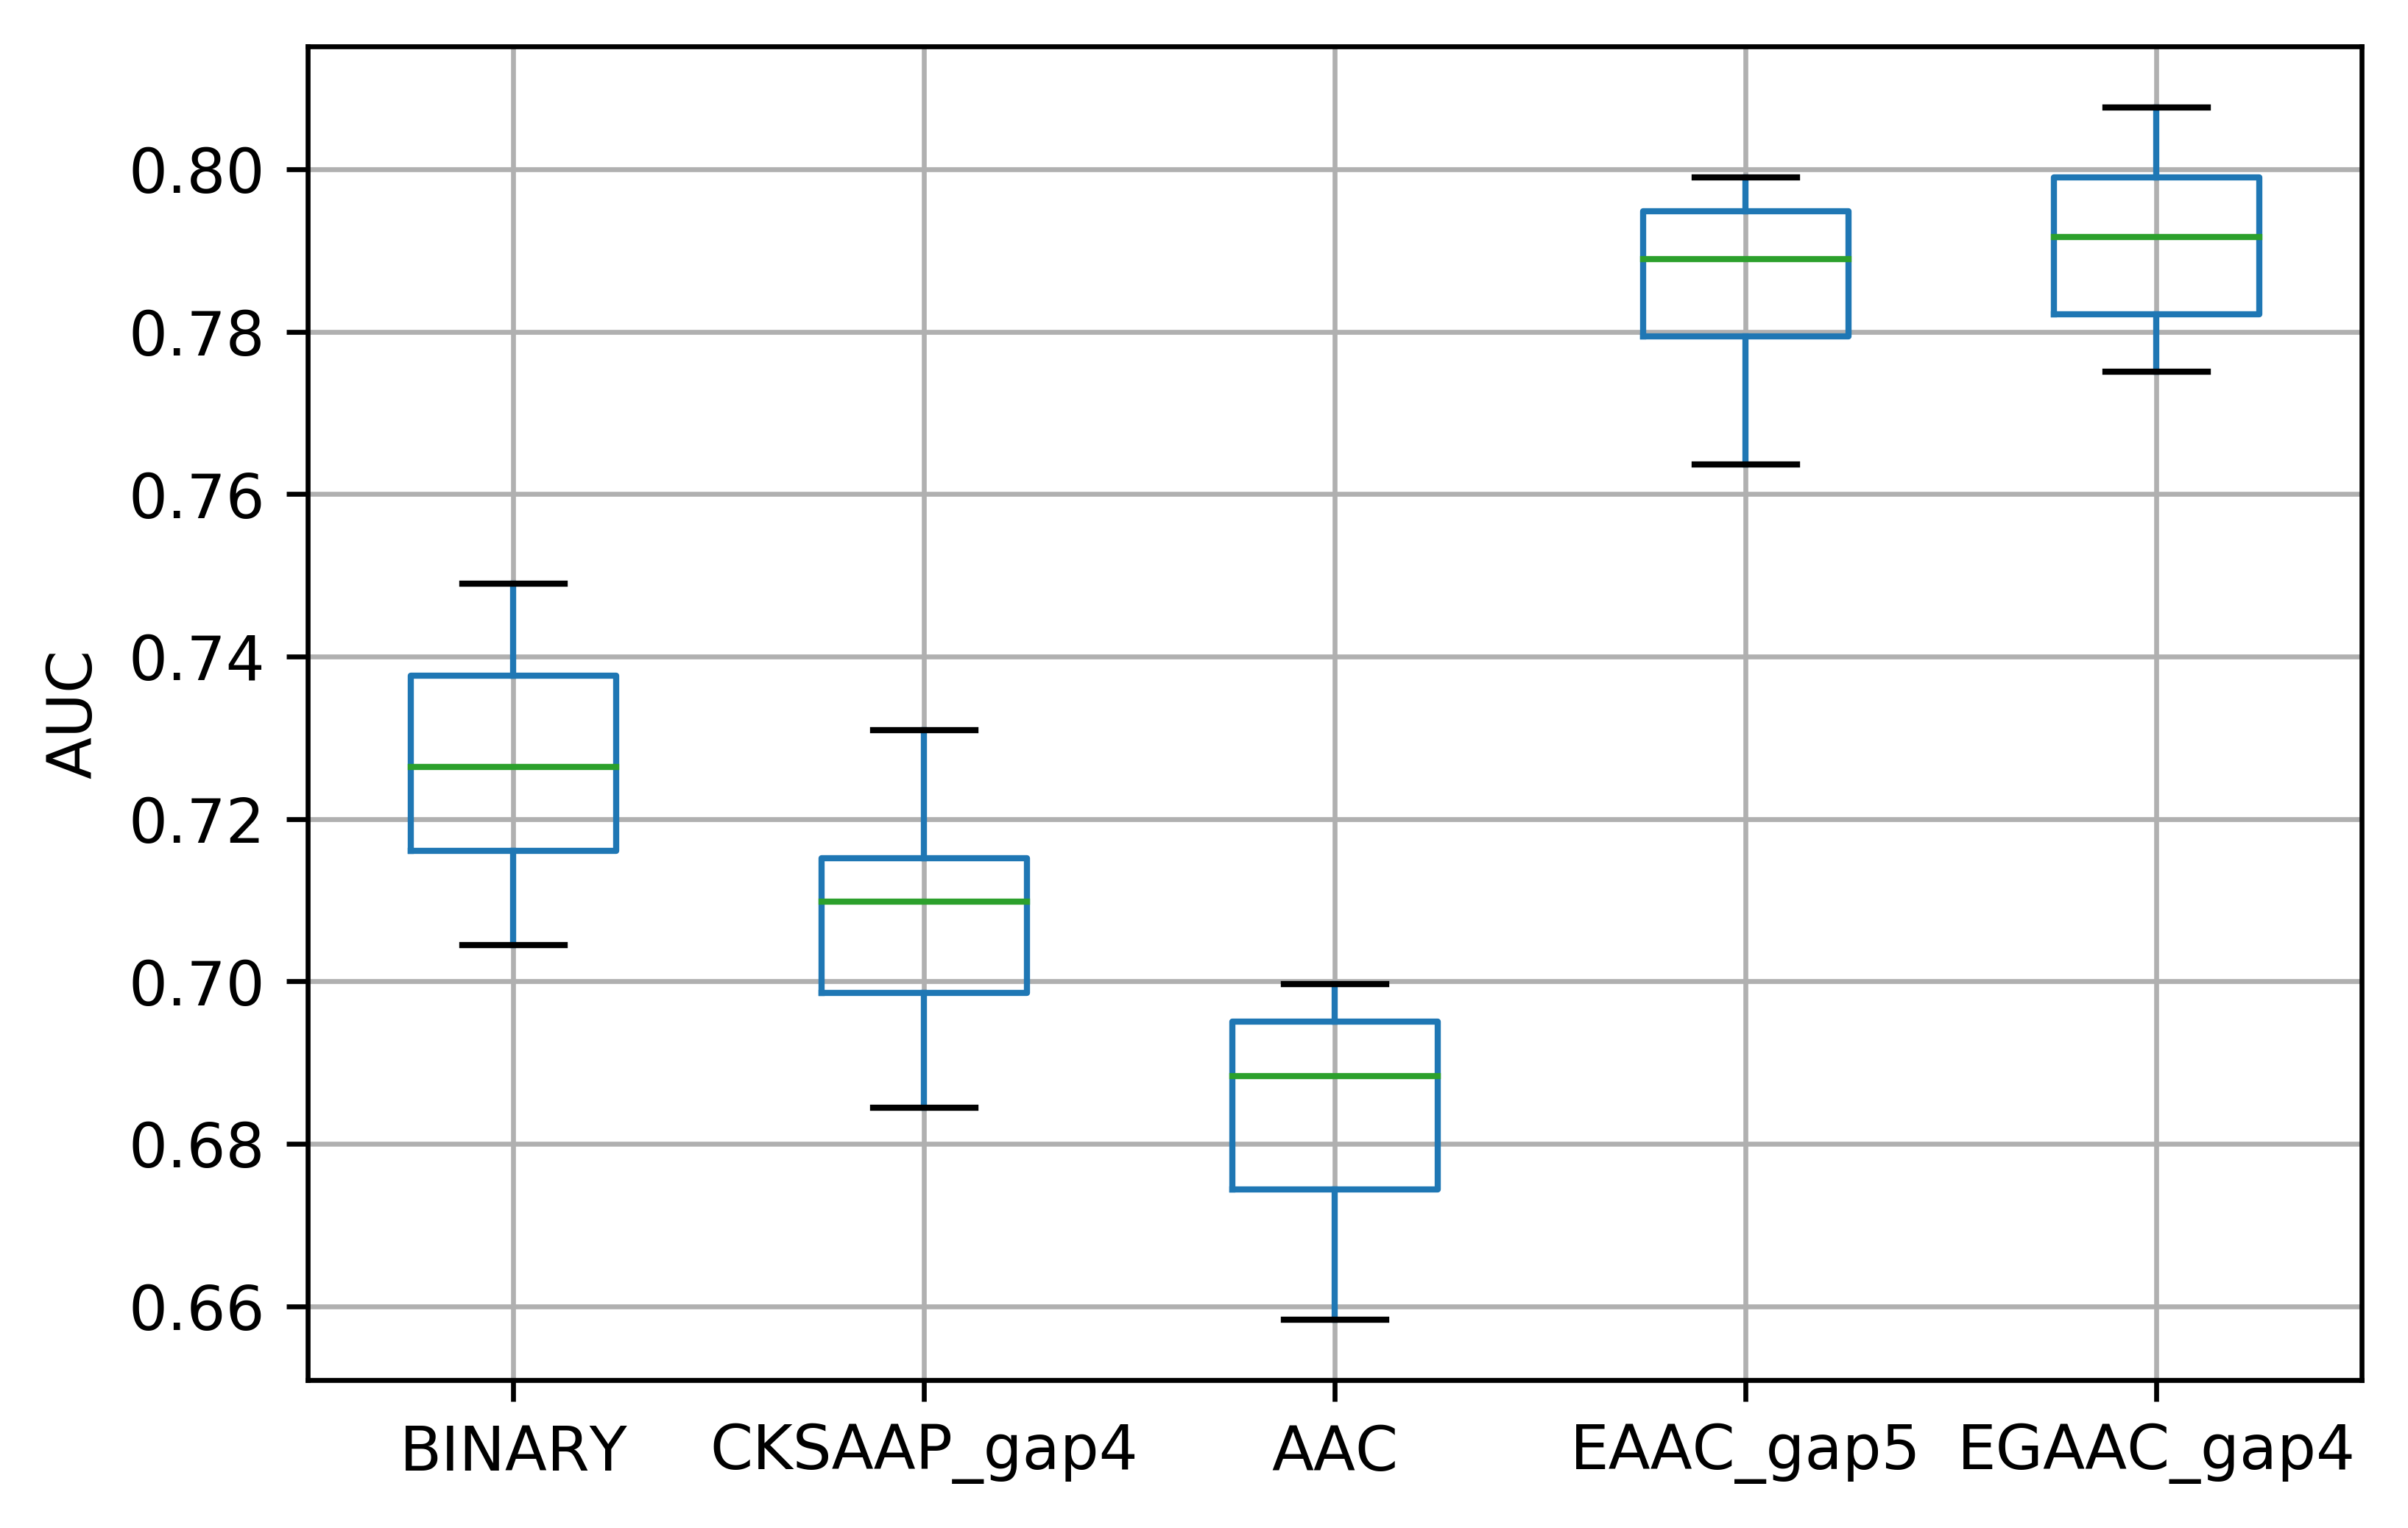

In [453]:
# RF
# 10 k-fold
# 箱线图
# 筛选特征
BINARY = [0.723361,0.71563,0.711014,0.748953,0.738242,0.704521,0.735801,0.743376,0.729422,0.717307]
BINARY_01 = [0.0139995,0.0195967,0.015495,0.0191304,0.0192827,0.0153877,0.0177918,0.0167652,0.0181078,0.0150561]

CKSAAP_gap4 = [0.708074,0.68444,0.711581,0.716382,0.71162,0.696588,0.704422,0.723463,0.730921,0.687607]
CKSAAP_gap4_01 = [0.0168178,0.0147625,0.0179792,0.0162938,0.0162046,0.0166559,0.0171903,0.0186685,0.0183134,0.014746]

AAC = [0.690762,0.668639,0.696056,0.692778,0.680706,0.672314,0.685876,0.699649,0.695781,0.658347]
AAC_01 = [0.0130995,0.012225,0.0153707,0.0125776,0.0135578,0.0125106,0.0142182,0.0141296,0.0132737,0.0130869]

EAAC_gap5 = [0.781925,0.778667,0.785795,0.799003,0.797184,0.770403,0.79413,0.795108,0.792157,0.763667]
EAAC_gap5_01 = [0.022627,0.0243358,0.0223781,0.0227487,0.0237099,0.0200422,0.0224273,0.0218883,0.022433,0.0206807]

EGAAC_gap4 = [0.783741,0.789916,0.793433,0.802873,0.796848,0.780132,0.799697,0.781684,0.807662,0.775109]
EGAAC_gap4_01 = [0.0208239,0.0223318,0.0229944,0.0223309,0.0243657,0.021223,0.0230216,0.0197138,0.023986,0.02083]

AUC_data ={
    'BINARY':BINARY,
    'CKSAAP_gap4':CKSAAP_gap4,
    'AAC':AAC,
    'EAAC_gap5':EAAC_gap5,
    'EGAAC_gap4':EGAAC_gap4
} 

df = pd.DataFrame(AUC_data )



columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
plt.ylabel('AUC')
df.boxplot() #也可用plot.box()

plt.savefig('C:/Users/Crow/Desktop/result/picture/AUC_data_600.png', dpi=600)
#plt.savefig('C:/Users/Crow/Desktop/result/picture/AUC_data_300.pdf', dpi=300)
plt.show()

AUC_p_value = [0.0013490127297701696,1.6442908228851423e-06,4.302832409975985e-11,0.06985709789741724]

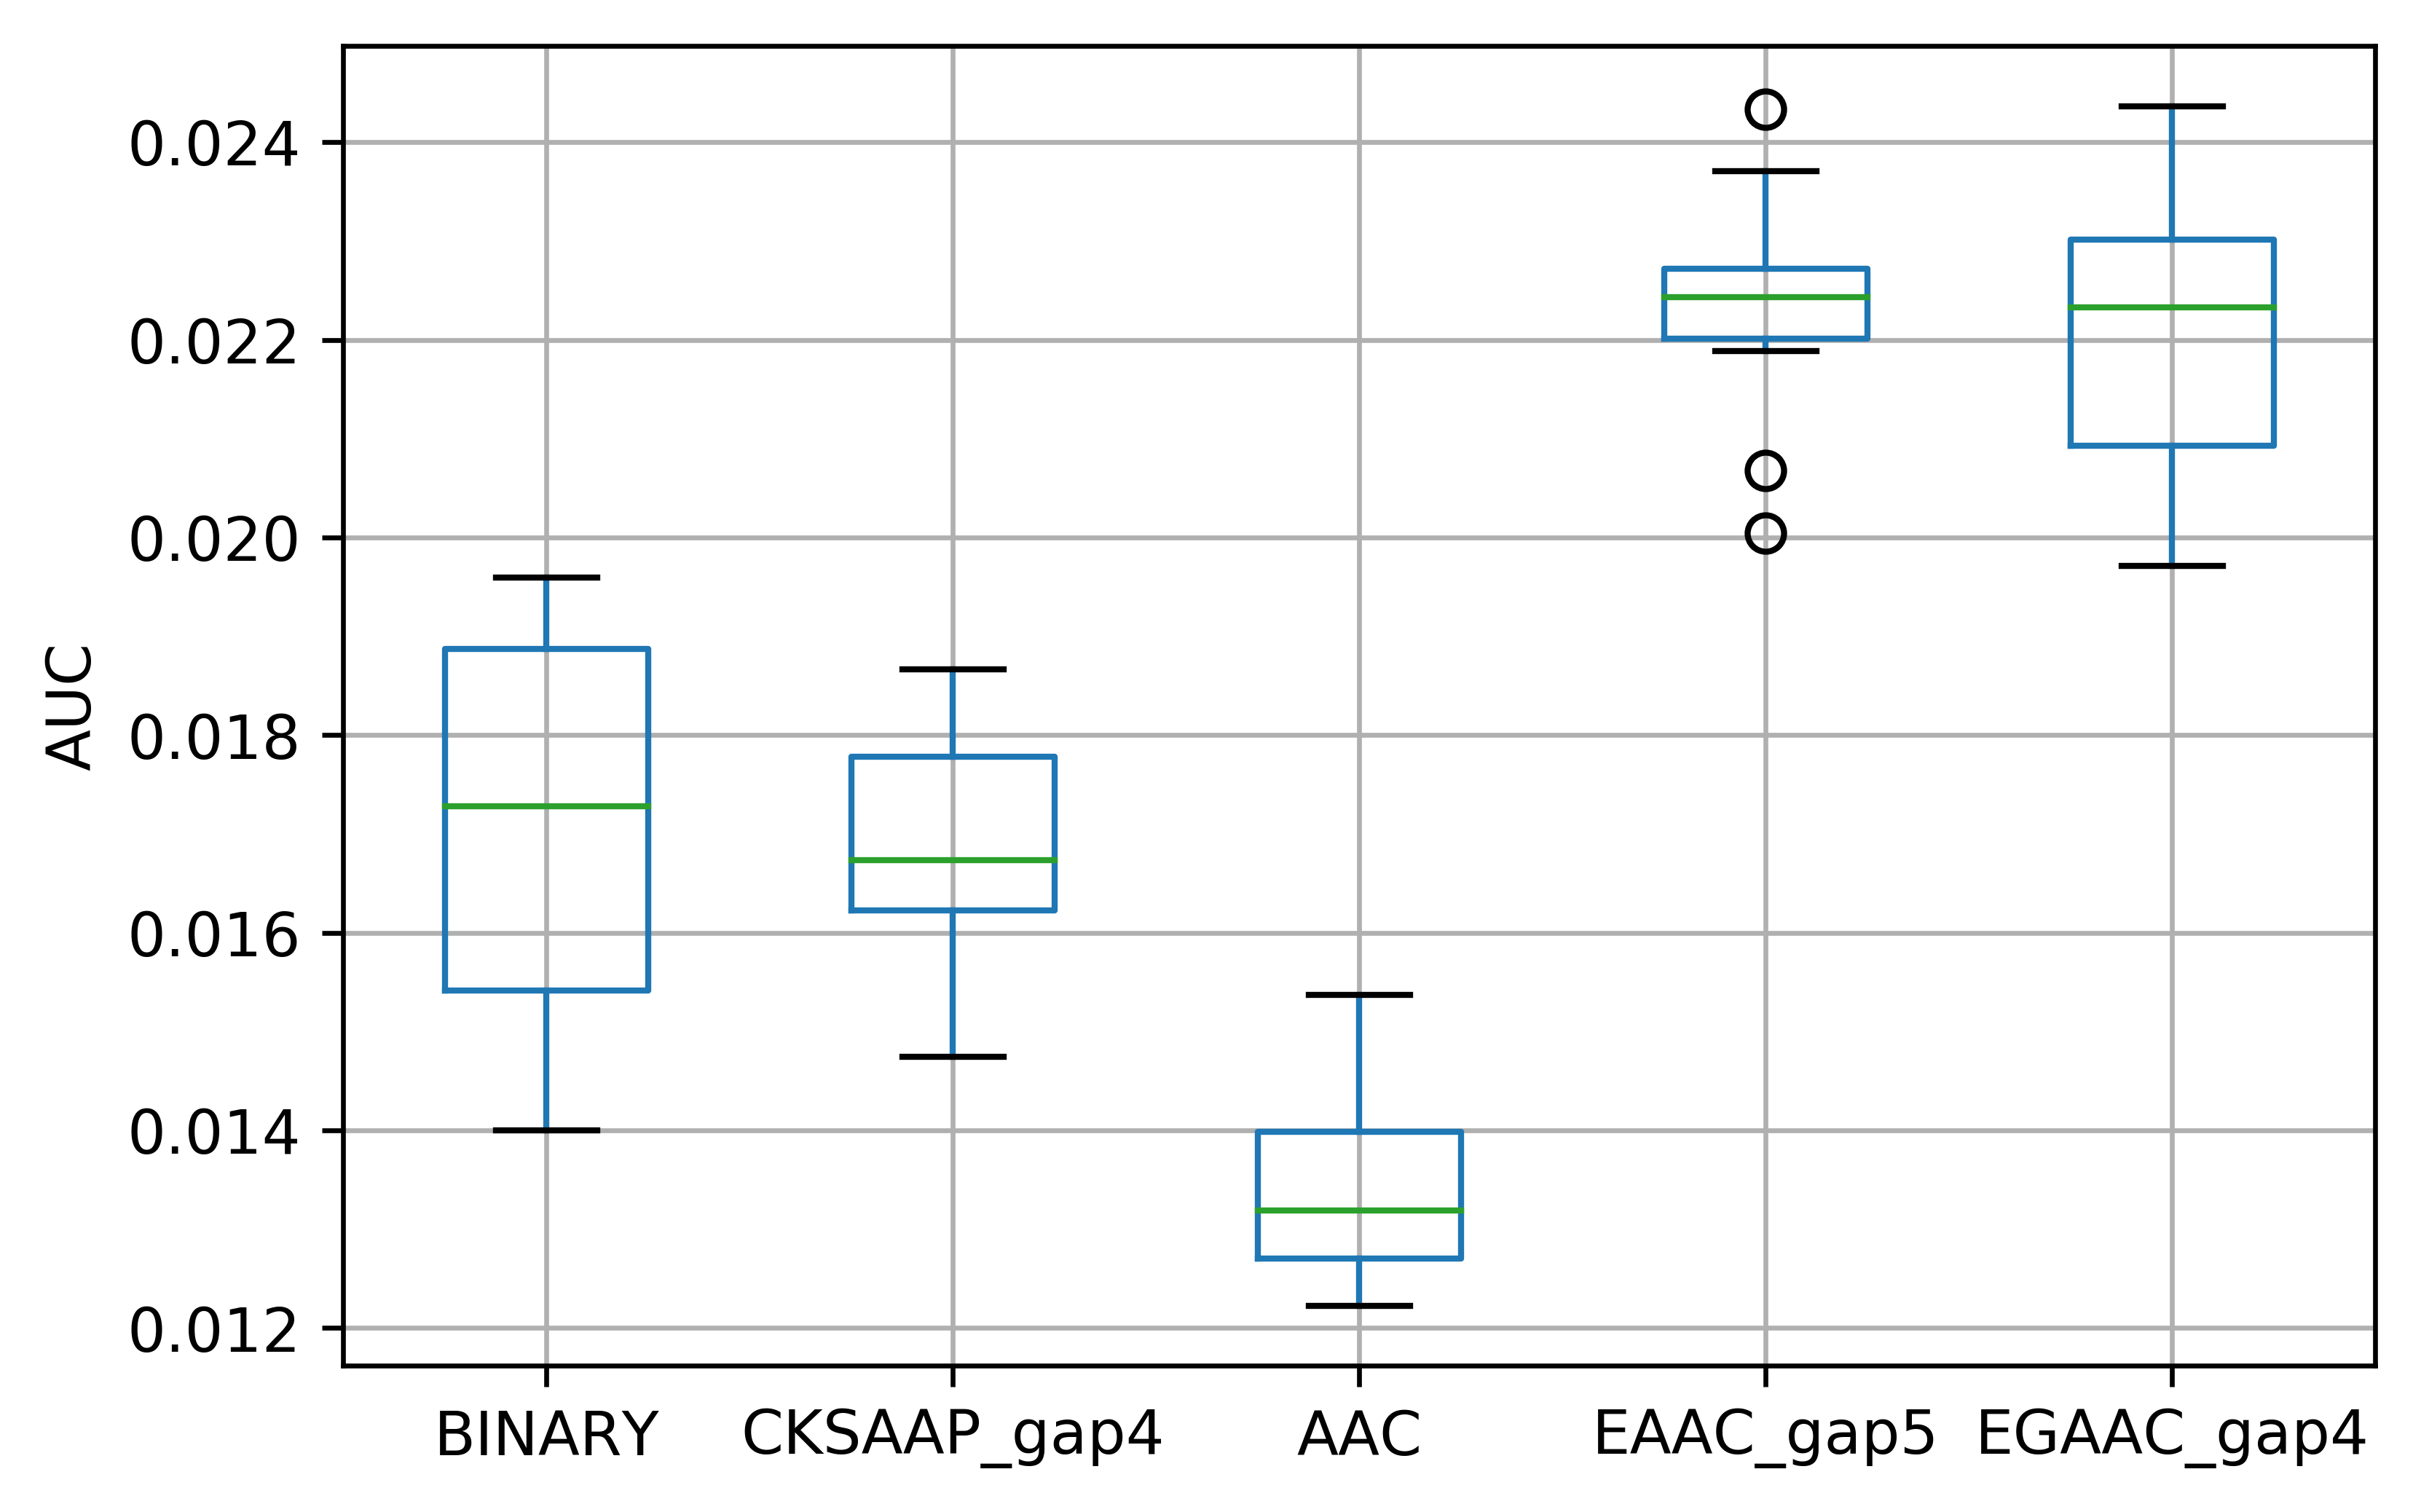

In [452]:
# AUC01  箱线图


AUC01_data ={
    'BINARY':BINARY_01,
    'CKSAAP_gap4':CKSAAP_gap4_01,
    'AAC':AAC_01,
    'EAAC_gap5':EAAC_gap5_01,
    'EGAAC_gap4':EGAAC_gap4_01
} 

df = pd.DataFrame(AUC01_data)



columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
plt.ylabel('AUC')
# plt.rcParams['figure.dpi'] = 600 
df.boxplot() #也可用plot.box()
# df.boxplot(                                        #上一节中计算的位置
#             boxprops={'color':'black'},      #设置box的颜色和线宽
#             flierprops={'marker':'x','markeredgecolor':'black'},    #设置异常点的形状和颜色
#             medianprops={'linestyle':'-','color':'black'},    #设置中位线的属性
#             capprops={'color':'black'},      #设置上下四分位线的属性
#             whiskerprops={'color':'black'})


# plt.show()
plt.savefig('C:/Users/Crow/Desktop/result/picture/AUC01_data_600.png', dpi=600)
plt.show()
plt.close()
AUC01_p_value = [0.7231445607596863,3.1934422633845855e-06,2.6701113030332513e-08,0.712137856428654]

In [422]:
# 配对样本t检验
a = [0.7231445607596863,3.1934422633845855e-06,2.6701113030332513e-08,0.712137856428654]
print(ttest_rel(EAAC_gap5_01,EGAAC_gap4_01))

Ttest_relResult(statistic=0.38086498818734715, pvalue=0.712137856428654)


In [62]:
# 象形图box plot 上添加t-test 
# 使用 https://github.com/webermarcolivier/statannot  包
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statannot import add_stat_annotation

In [236]:
# RF 十折交叉检验数据
# 箱线图绘制
BINARY = [0.723361,0.71563,0.711014,0.748953,0.738242,0.704521,0.735801,0.743376,0.729422,0.717307]
BINARY_01 = [0.0139995,0.0195967,0.015495,0.0191304,0.0192827,0.0153877,0.0177918,0.0167652,0.0181078,0.0150561]

CKSAAP_gap4 = [0.708074,0.68444,0.711581,0.716382,0.71162,0.696588,0.704422,0.723463,0.730921,0.687607]
CKSAAP_gap4_01 = [0.0168178,0.0147625,0.0179792,0.0162938,0.0162046,0.0166559,0.0171903,0.0186685,0.0183134,0.014746]

AAC = [0.690762,0.668639,0.696056,0.692778,0.680706,0.672314,0.685876,0.699649,0.695781,0.658347]
AAC_01 = [0.0130995,0.012225,0.0153707,0.0125776,0.0135578,0.0125106,0.0142182,0.0141296,0.0132737,0.0130869]

EAAC_gap5 = [0.781925,0.778667,0.785795,0.799003,0.797184,0.770403,0.79413,0.795108,0.792157,0.763667]
EAAC_gap5_01 = [0.022627,0.0243358,0.0223781,0.0227487,0.0237099,0.0200422,0.0224273,0.0218883,0.022433,0.0206807]

EGAAC_gap4 = [0.783741,0.789916,0.793433,0.802873,0.796848,0.780132,0.799697,0.781684,0.807662,0.775109]
EGAAC_gap4_01 = [0.0208239,0.0223318,0.0229944,0.0223309,0.0243657,0.021223,0.0230216,0.0197138,0.023986,0.02083]

AUC_data ={
    'BINARY':BINARY,
    'CKSAAP_gap4':CKSAAP_gap4,
    'AAC':AAC,
    'EAAC_gap5':EAAC_gap5,
    'EGAAC_gap4':EGAAC_gap4
} 


AUC01_data ={
    'BINARY':BINARY_01,
    'CKSAAP_gap4':CKSAAP_gap4_01,
    'AAC':AAC_01,
    'EAAC_gap5':EAAC_gap5_01,
    'EGAAC_gap4':EGAAC_gap4_01
}

df = pd.DataFrame(AUC_data)
df_01 = pd.DataFrame(AUC01_data)


columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4']





In [237]:
df

,BINARY,CKSAAP_gap4,AAC,EAAC_gap5,EGAAC_gap4
0,0.723361,0.708074,0.690762,0.781925,0.783741
1,0.715630,0.684440,0.668639,0.778667,0.789916
2,0.711014,0.711581,0.696056,0.785795,0.793433
3,0.748953,0.716382,0.692778,0.799003,0.802873
4,0.738242,0.711620,0.680706,0.797184,0.796848
5,0.704521,0.696588,0.672314,0.770403,0.780132
6,0.735801,0.704422,0.685876,0.794130,0.799697
7,0.743376,0.723463,0.699649,0.795108,0.781684
8,0.729422,0.730921,0.695781,0.792157,0.807662
9,0.717307,0.687607,0.658347,0.763667,0.775109


AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=1.644e-06 stat=-1.097e+01
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=1.349e-03 stat=-4.569e+00
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=3.212e-09 stat=-2.250e+01
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=6.986e-02 stat=-2.057e+00


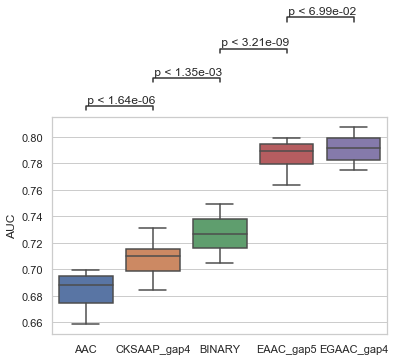

In [107]:
"""
seaborn的5种主题风格:
    darkgrid
    whitegrid
    dark
    white
    ticks
"""
sns.set(style="whitegrid")
ax = sns.boxplot(data=df,  order=columns)
plt.ylabel("AUC")
add_stat_annotation(ax, data=df, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4")],
                    test='t-test_paired', textFormat='full', loc='outside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/result/picture/RF_result/AUC_RF_data_stat_300.png', dpi=300,bbox_inches='tight')

AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=3.193e-06 stat=-1.014e+01
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=7.231e-01 stat=-3.656e-01
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=1.248e-06 stat=-1.134e+01
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=7.121e-01 stat=3.809e-01


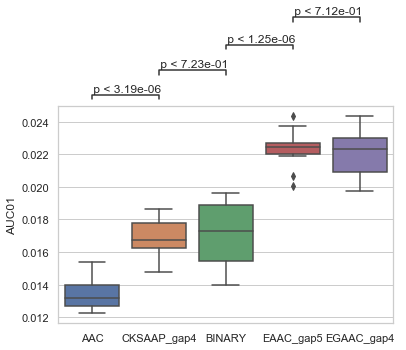

In [108]:
# 接上
# RF 十折交叉检验 AUC01 箱线图绘制
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4']

sns.set(style="whitegrid")
ax = sns.boxplot(data=df_01,order=columns)
plt.ylabel("AUC01")
add_stat_annotation(ax, data=df_01, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4")],
                    test='t-test_paired', textFormat='full', loc='outside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/result/picture/RF_result/AUC01_RF_data_stat_300.png', dpi=300,bbox_inches='tight')

AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=2.338e-06 stat=-1.052e+01
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=1.229e-04 stat=-6.416e+00
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=8.466e-06 stat=-9.009e+00
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=7.908e-04 stat=-4.950e+00
EGAAC_gap4 v.s. Embedding: t-test paired samples, P_val=1.304e-09 stat=-2.490e+01


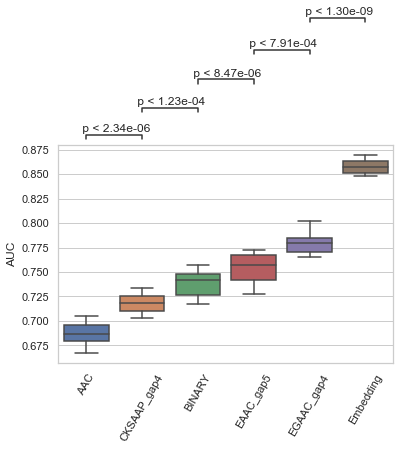

In [111]:
# CNN model boxplot   paired t-test

# CNN 10-fold 后数据
# CNN 画箱线图 和 配对t-test
BINARY = [0.74858,0.72531,0.729377,0.746291,0.757209,0.716943,0.740705,0.748711,0.742049,0.718348]
BINARY_01 = [0.0193452,0.0188348,0.0163788,0.0192694,0.0200857,0.015796,0.019242,0.0188909,0.0187123,0.0156583]

CKSAAP_gap4 = [0.727375,0.702889,0.718538,0.715293,0.720199,0.705757,0.71776,0.733371,0.732077,0.708407]
CKSAAP_gap4_01 = [0.0184811,0.0164841,0.0182857,0.0167354,0.0165019,0.017638,0.0175967,0.0206279,0.0198656,0.0172003]

AAC = [0.697583,0.679292,0.687933,0.705022,0.684746,0.674327,0.679923,0.691915,0.704359,0.667148]
AAC_01 = [0.0133235,0.0137827,0.0143659,0.0125646,0.013833,0.0137815,0.0134525,0.0149948,0.0136725,0.0121731]

EAAC_gap5 = [0.758458,0.733854,0.751117,0.765943,0.772624,0.727126,0.756891,0.772324,0.767318,0.738252]
EAAC_gap5_01 = [0.0230343,0.0199245,0.0208168,0.0205771,0.0221402,0.0196654,0.019176,0.0217752,0.0213537,0.0189261]

EGAAC_gap4 = [0.780899,0.777842,0.769064,0.785129,0.782205,0.775279,0.790265,0.76701,0.802266,0.765053]
EGAAC_gap4_01 = [0.0228899,0.0214292,0.0222644,0.0208791,0.0235234,0.020972,0.0223185,0.0208777,0.0250482,0.0191102]

Embedding = [0.854307,0.850165,0.855998,0.869378,0.863474,0.848972,0.858895,0.86415,0.865656,0.848028]
Embedding_01 = [0.0302004,0.0304466,0.033405,0.0348931,0.0315187,0.0302907,0.0319394,0.0327611,0.0330019,0.0298258]

AUC_data ={
    'BINARY':BINARY,
    'CKSAAP_gap4':CKSAAP_gap4,
    'AAC':AAC,
    'EAAC_gap5':EAAC_gap5,
    'EGAAC_gap4':EGAAC_gap4,
    'Embedding':Embedding
} 


AUC01_data ={
    'BINARY':BINARY_01,
    'CKSAAP_gap4':CKSAAP_gap4_01,
    'AAC':AAC_01,
    'EAAC_gap5':EAAC_gap5_01,
    'EGAAC_gap4':EGAAC_gap4_01,
    'Embedding':Embedding_01
}

df = pd.DataFrame(AUC_data)
df_01 = pd.DataFrame(AUC01_data)


columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4','Embedding']
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4','Embedding']



sns.set(style="whitegrid")
ax = sns.boxplot(data=df,order=columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.ylabel("AUC")
add_stat_annotation(ax, data=df, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4"),('EGAAC_gap4','Embedding')],
                    test='t-test_paired', textFormat='full', loc='outside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/result/picture/CNN_result/AUC_CNN_data_stat_300.png', dpi=300,bbox_inches='tight')

AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=8.840e-07 stat=-1.181e+01
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=6.891e-01 stat=-4.133e-01
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=3.214e-04 stat=-5.631e+00
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=2.654e-02 stat=-2.649e+00
EGAAC_gap4 v.s. Embedding: t-test paired samples, P_val=1.031e-07 stat=-1.516e+01


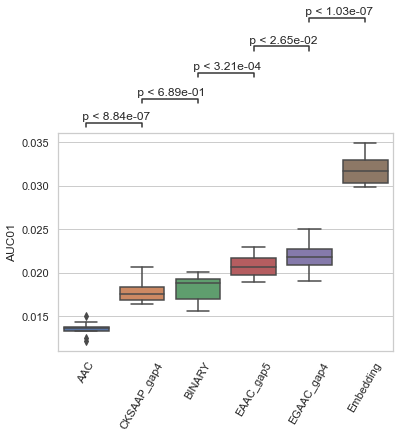

In [113]:
# 接上
# CNN 十折交叉检验 AUC01 箱线图绘制
sns.set(style="whitegrid")
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4','Embedding']

ax = sns.boxplot(data=df_01,order=columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


plt.ylabel("AUC01")
add_stat_annotation(ax, data=df_01, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4"),('EGAAC_gap4','Embedding')],
                    test='t-test_paired', textFormat='full', loc='outside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/result/picture/CNN_result/AUC01_CNN_data_stat_300.png', dpi=300,bbox_inches='tight')


In [471]:
sns.set(style="white")

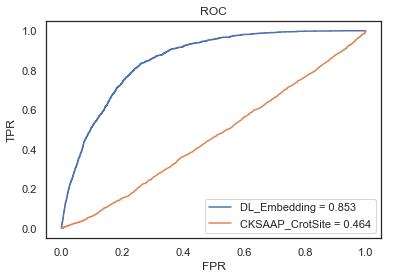

In [472]:
# DL-embedding 与 CKSAAP_CrotSite的性能比较
q = ['Embedding','CKSAAP_CrotSite']
q2=[0.853252]
q3=[0.0307755]


data_Embedding = pd.read_table('c:/Users/Crow/Desktop/human_data_12.12/result/DL_result/Test_keras_29_Embedding_ROC01_result.txt')
data_CKSAAP_CrotSite = pd.read_table('C:/Users/Crow/Desktop/result/CKSAAP_sites_ROC01_result.txt')

#data2 = data[data['x-axie']<=0.1]
plt.title('ROC')
plt.plot(data_Embedding['x-axie'], data_Embedding['y-axie'],label='DL_Embedding' + ' = %0.3f'%0.853252)

plt.plot(data_CKSAAP_CrotSite['x-axie'], data_CKSAAP_CrotSite['y-axie'],label='CKSAAP_CrotSite' + ' = %0.3f'%0.4641598974790915)


plt.legend(loc='lower right')
#plt.plot([0,0.1],[0,1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
#plt.savefig('c:/Users/Crow/Desktop/result/picture/Embedding_CKSAAP_CrotSite.png',dpi=600)
plt.close(0)

In [484]:
# 从pkl文件导入RFmodel
# 预测 CV 和 IND 数据，输出文本
# 经过1.sh 批量输出roc01 和 cutoff


name = 'EGAAC'
gap = '_gap4'


clf = joblib.load('C:/Users/Crow/Desktop/result/model/clf_kfold_'+ name + gap +'.pkl')
path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

train = read_svm(path_train)
test = read_svm(path_test)


x_train = train[0]
y_train = train[1]

x_test = test[0]
y_test = test[1]



train_pred_proba = clf.predict_proba(x_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train,train_pred_proba,pos_label=1)
print("CV AUC: %f" % auc(fpr, tpr))
fw = open('C:/Users/Crow/Desktop/result/rf_result/29_kfold_'+ name + gap+'_cv_result.txt','w')

for t in range(0,len(train_pred_proba)):
    fw.write(str(train_pred_proba[t]))
    fw.write('\t')
    fw.write(str(y_train[t]))
    fw.write('\n')
fw.close()



test_pred_proba = clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
print("IND AUC: %f" % auc(fpr, tpr))
fw = open('C:/Users/Crow/Desktop/result/rf_result/29_kfold_'+ name + gap+'_ind_result.txt','w')

for t in range(0,len(test_pred_proba)):
    fw.write(str(test_pred_proba[t]))
    fw.write('\t')
    fw.write(str(y_test[t]))
    fw.write('\n')
fw.close()

CV AUC: 0.898027
IND AUC: 0.782930


In [16]:
# 从文本中获取cutoff
# 设置相应cutoff，得到 AC Sn Sp Mcc AUC AUC01 

def read_result(path):
    result = pd.read_table(path)
    for i in range(0,len(result)):
        if result['Sp'][i] >= 0.9 and result['Sp'][i+1] <0.9:
            print("Sp:  %f "  %result['Sp'][i])
            print("Cutoff:  %f "  %result['<<Cutoff'][i])


In [16]:
# 读取Sp  cutoff

# names = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
names = ['EGAAC_gap4','CKSAAP_gap4','EAAC_gap5','AAC','BINARY','Embedding']
q = [21,23,25,27,29,31,35,37]
q=[29]
#q = [29]
t = 29
for name in names :
    print(name)
    path_test='C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ name +'_ind_ROC_result.txt'
    print('test: %i'%t)
    read_result(path_test)
    
    print('')

    
for name in names :
    print(name)
    path_train='C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ name +'_cv_ROC_result.txt'
    print('train:  %i'%t)
    read_result(path_train)
    print('')
    

EGAAC_gap4
test: 29
Sp:  0.900042 
Cutoff:  0.229254 


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """



CKSAAP_gap4
test: 29
Sp:  0.900042 
Cutoff:  0.163830 

EAAC_gap5
test: 29
Sp:  0.900042 
Cutoff:  0.219976 

AAC
test: 29
Sp:  0.900042 
Cutoff:  0.161246 

BINARY
test: 29
Sp:  0.900042 
Cutoff:  0.226715 

Embedding
test: 29
Sp:  0.900042 
Cutoff:  0.309294 

EGAAC_gap4
train:  29
Sp:  0.900009 
Cutoff:  0.223923 

CKSAAP_gap4
train:  29
Sp:  0.900009 
Cutoff:  0.156878 

EAAC_gap5
train:  29
Sp:  0.900009 
Cutoff:  0.211341 

AAC
train:  29
Sp:  0.900009 
Cutoff:  0.162764 

BINARY
train:  29
Sp:  0.900009 
Cutoff:  0.219773 

Embedding
train:  29
Sp:  0.900009 
Cutoff:  0.290481 



In [17]:
# 读取 AUC AUC01
names = ['EGAAC_gap4','CKSAAP_gap4','EAAC_gap5','AAC','BINARY','Embedding']
gap = ''
q = [29]
t = 29
for name in names:
    print(name)
    path_test='C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ name +'_ind_ROC01_result.txt'
    print('test: %i'%t)
    fr = open(path_test,'r')
    for i in range(2):
        print(fr.readline().split(':')[1])
    fr.close() 

    
for name in names:
    print(name)
    path_train='C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ name +'_cv_ROC01_result.txt'
    print('train:  %i'%t)
    print('')
    fr = open(path_train,'r')
    for i in range(2):
        print(fr.readline().split(':')[1])
    fr.close() 

EGAAC_gap4
test: 29
 0.771556

 0.0198363

CKSAAP_gap4
test: 29
 0.699561

 0.0137952

EAAC_gap5
test: 29
 0.74616

 0.0196674

AAC
test: 29
 0.669962

 0.0119581

BINARY
test: 29
 0.744473

 0.017798

Embedding
test: 29
 0.857359

 0.030444

EGAAC_gap4
train:  29

 0.814189

 0.0279014

CKSAAP_gap4
train:  29

 0.818898

 0.0324525

EAAC_gap5
train:  29

 0.827572

 0.032279

AAC
train:  29

 0.70878

 0.0152233

BINARY
train:  29

 0.798277

 0.0273916

Embedding
train:  29

 0.905943

 0.0463366



In [21]:
# 根据cutoff 计算  AC Sn  Mcc
names = ['EGAAC_gap4','CKSAAP_gap4','EAAC_gap5','AAC','BINARY','Embedding']
# names = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']



train_cutoff = [0.223923,0.156878,0.211341,0.162764,0.219773,0.290481]
test_cutoff = [0.229254,0.163830,0.219976,0.161246,0.226715,0.309294]

for c in range(5,6):
    #clf = joblib.load('C:/Users/Crow/Desktop/result/model/clf_kfold_'+ names[c] +'.pkl')
    #model = load_model('C:/Users/Crow/Desktop/result/model/CNN_kfold_'+ names[c]+'.h5')
    if names[c] == 'Embedding':
        path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Train.txt'
        path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'

        x_train,y_train = pep(path_train,29-2)
        x_test,y_test = pep(path_test,29-2)
    else :
        path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ names[c].split('_')[0] +'/Train_29_'+ names[c] +'.txt'
        path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ names[c].split('_')[0] +'/Test_29_'+ names[c]  +'.txt'
        train = read_svm(path_train)
        test = read_svm(path_test)


        x_train = train[0]
        y_train = train[1]

        x_test = test[0]
        y_test = test[1]

        x_train = np.expand_dims(x_train, axis=2) 
        x_test = np.expand_dims(x_test, axis=2) 
    


    print(names[c])
    
    path_test_result = 'C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ names[c] +'_ind_result.txt'
    path_train_result = 'C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ names[c] +'_cv_result.txt'
    
    test_result = pd.read_table(path_test_result, header=None)

    train_result = pd.read_table(path_train_result, header=None)
    
    test_result_score = test_result[0]
    test_pred = np.array(test_result[1])
    
    train_result_score = train_result[0]
    train_pred = np.array(train_result[1])
    
                          
    for i in range(0,len(test_result_score)):
        if test_result_score[i] > test_cutoff[c]:       
            test_pred[i] = 1
        else:
            test_pred[i] = 0

    fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
    print(names[c])
    print('test:')
    print("ACC:  %f "  %accuracy_score(y_test,test_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_test,test_result_score))
    
    
    for i in range(0,len(train_result_score)):
        if train_result_score[i] > train_cutoff[c]:       
            train_pred[i] = 1
        else:
            train_pred[i] = 0
    fpr, tpr, thresholds = roc_curve(y_train,train_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_train,train_pred)
    print(names[c])
    print('train:')
    print("ACC:  %f "  %accuracy_score(y_train,train_pred))
    print("Sn: %f" %SN)
    print("Sp: %f" %SP)
    print("MCC: %f " %matthews_corrcoef(y_train,train_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_train,train_result_score))

Embedding


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


Embedding
test:
ACC:  0.868799 
Sn: 0.521241
Sp: 0.900042
MCC: 0.339456 
AUC: 0.857359
AUC: 0.857359
Embedding
train:
ACC:  0.879975 
Sn: 0.678780
Sp: 0.900024
MCC: 0.462268 
AUC: 0.905943
AUC: 0.905943


In [30]:
# CNN 十折交叉检验 输出每一折result  和最终的cv ind result
# 
name = 'Embedding'
gap = ''


model = load_model('C:/Users/Crow/Desktop/result/model/CNN_kfold_'+ name + gap +'.h5')

# path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/'+ name +'/Train_29_'+ name + gap +'.txt'
# path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

# train = read_svm(path_train)
# test = read_svm(path_test)


# x_train = train[0]
# y_train = train[1]

# x_test = test[0]
# y_test = test[1]

# x_train = np.expand_dims(x_train, axis=2) 
# x_test = np.expand_dims(x_test, axis=2) 
path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Train.txt'
path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'

x_train,y_train = pep(path_train,29-2)
x_test,y_test = pep(path_test,29-2)




train_pred_proba = model.predict(x_train)
fpr, tpr, thresholds = roc_curve(y_train,train_pred_proba,pos_label=1)
print("CV AUC: %f" % auc(fpr, tpr))
fw = open('C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ name + gap+'_cv_result.txt','w')

for t in range(0,len(train_pred_proba)):
    fw.write(str(train_pred_proba[t][0]))
    fw.write('\t')
    fw.write(str(y_train[t]))
    fw.write('\n')
fw.close()



test_pred_proba = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
print("IND AUC: %f" % auc(fpr, tpr))
fw = open('C:/Users/Crow/Desktop/result/CNN_result/29_kfold_CNN_'+ name + gap+'_ind_result.txt','w')

for t in range(0,len(test_pred_proba)):
    fw.write(str(test_pred_proba[t][0]))
    fw.write('\t')
    fw.write(str(y_test[t]))
    fw.write('\n')
fw.close()

CV AUC: 0.905943
IND AUC: 0.857359


In [95]:
# 读取数据文件 输出为Excel
path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_CV/Train_29.txt'
path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/Test_29.txt'

data_train = pd.read_table(path_train,header=None)
data_train.columns = ['h','Peptide','UniProt ID','Position','Sample label']

data_test = pd.read_table(path_test,header=None)
data_test.columns = ['h','Peptide','UniProt ID','Position','Sample label']

data_test = data_test.drop(columns=['h'])
data_train = data_train.drop(columns=['h'])

data_train.head()
data_train.to_excel('C:/Users/Crow/Desktop/result/train.xlsx')
data_test.to_excel('C:/Users/Crow/Desktop/result/test.xlsx')

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


,h,Peptide,UniProt ID,Position,Sample label
0,0,GRIYELRLMMDFDGKNRGYAFVMYCHKHE,A0AV96,109,1
1,1,EGSCLEVTLAKPVDKEQYSRYQKAARGGG,A0AV96,321,1
2,2,YSAGRGIYSRYHEGKGKQQEKGYELVPNL,A0AV96,415,1
3,3,VLNSEVLEQRKVLEKCNRVSMLAVEEYEE,A0MZ66,202,1
4,4,QLELLEEDKKELELKYQNSEEKARNLKHS,A0MZ66,323,1


In [118]:
# 读取pdf文件
import tabula

df = tabula.read_pdf('C:/Users/Crow/Desktop/1-s2.0-S0888754317301386-mmc3.pdf', encoding='gbk', pages='all',multiple_tables=True)

In [198]:
df[24]



,0,1,2,3
0,832,U3KQK0,137,TKYTSSKKRKRRFTESIKKAHGFRKLKIWLKLRVS
1,833,U3KQK0,138,KYTSSKKRKRRFTESIKKAHGFRKLKIWLKLRVSN
2,834,U3KQK0,144,KRKRRFTESIKKAHGFRKLKIWLKLRVSNQSPDDI
3,835,U3KQK0,146,KRRFTESIKKAHGFRKLKIWLKLRVSNQSPDDIYI
4,836,U3KQK0,150,TESIKKAHGFRKLKIWLKLRVSNQSPDDIYIARDD
5,837,Q5TEC6,65,ALREIRRYQKSTELLIRKLPFQRLVREIAQEFKTD
6,838,Q5TEC6,80,IRKLPFQRLVREIAQEFKTDLRFQSSAVMALQEAR
7,839,Q5TEC6,116,AYLVGLFEDTNLCAIHAKRVTIMPKDIQLVSRIRG
8,840,Q5TEC6,123,EDTNLCAIHAKRVTIMPKDIQLVSRIRGERAAAAA
9,841,I6L9F7,117,RLLLPGELAKHAVSEGTKAVTKYTSSKCASRCSNS


In [199]:
# histone  no-histone train dataset 查重输出到文件
path_test =  'C:/Users/Crow/Desktop/histone_train.txt'
histone_data = pd.read_table(path_test,names= ['Sequences', 'Protein ID', 'Site', 'Label'])

path_train = 'C:/Users/Crow/Desktop/human_data_12.12/Train.txt'
path_test2 =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'
human_train = pd.read_table(path_train,names= ['Sequences', 'Protein ID', 'Site', 'Label'])
human_test = pd.read_table(path_test2,names= ['Sequences', 'Protein ID', 'Site', 'Label'])
# 查重输出文件
a = human_train.append(histone_data)
#a = histone_data.append(human_train)
dIndex = a.duplicated(['Protein ID', 'Site'])
b = a[dIndex]
b.to_excel('C:/Users/Crow/Desktop/hhh.xlsx')

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


In [ ]:
# !!! 思路错误
# 读取10折交叉检验result文件 ，计算平均score
names = ['EGAAC_gap4','CKSAAP_gap4','EAAC_gap5','AAC','BINARY','Embedding']
j = 1
score = []
for name in names:
    result_path = 'C:/Users/Crow/Desktop/result/29_kfold_'+ name +'_result_'+ str(j) +'.txt'
    
    score = [score[i]+b[i] for i in range(0,len(score))] 

In [268]:
BINARY = [0.723361,0.71563,0.711014,0.748953,0.738242,0.704521,0.735801,0.743376,0.729422,0.717307]
BINARY_01 = [0.0139995,0.0195967,0.015495,0.0191304,0.0192827,0.0153877,0.0177918,0.0167652,0.0181078,0.0150561]

CKSAAP_gap4 = [0.708074,0.68444,0.711581,0.716382,0.71162,0.696588,0.704422,0.723463,0.730921,0.687607]
CKSAAP_gap4_01 = [0.0168178,0.0147625,0.0179792,0.0162938,0.0162046,0.0166559,0.0171903,0.0186685,0.0183134,0.014746]

AAC = [0.690762,0.668639,0.696056,0.692778,0.680706,0.672314,0.685876,0.699649,0.695781,0.658347]
AAC_01 = [0.0130995,0.012225,0.0153707,0.0125776,0.0135578,0.0125106,0.0142182,0.0141296,0.0132737,0.0130869]

EAAC_gap5 = [0.781925,0.778667,0.785795,0.799003,0.797184,0.770403,0.79413,0.795108,0.792157,0.763667]
EAAC_gap5_01 = [0.022627,0.0243358,0.0223781,0.0227487,0.0237099,0.0200422,0.0224273,0.0218883,0.022433,0.0206807]

EGAAC_gap4 = [0.783741,0.789916,0.793433,0.802873,0.796848,0.780132,0.799697,0.781684,0.807662,0.775109]
EGAAC_gap4_01 = [0.0208239,0.0223318,0.0229944,0.0223309,0.0243657,0.021223,0.0230216,0.0197138,0.023986,0.02083]

In [272]:
mean(BINARY_01)

0.01706129

In [26]:
# 2019.3.11
# 读取文档 获得 AUC
name='Embedding'
gap=''
a = []
b = []
for i in range(1,11):
    path = 'C:/Users/Crow/Desktop/new_result/CNN/result/29_kfold_CNN_'+name+gap+'_result_ROC01_result_'+str(i)+'.txt'
    fr = open(path,'r')
    for line in fr.readlines()[0:1]:
        print(line.split(':')[1].split('\n')[0])
        a.append(float(line.split(':')[1].split('\n')[0]))
        print(',')
    fr.close()
    fr = open(path,'r')
    for line in fr.readlines()[1:2]:
        print(line.split(':')[1].split('\n')[0])
        b.append(float(line.split(':')[1].split('\n')[0]))
        print(',')
    fr.close()
    #print('\n')

 0.864151
,
 0.0308802
,
 0.859165
,
 0.0324699
,
 0.863823
,
 0.0352481
,
 0.867803
,
 0.034341
,
 0.871516
,
 0.0318046
,
 0.84857
,
 0.031575
,
 0.864756
,
 0.0314986
,
 0.869022
,
 0.0324783
,
 0.870196
,
 0.033116
,
 0.855489
,
 0.0298011
,


In [60]:
# 最新RF十折交叉检验
# 读取Sp  cutoff

# names = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
#names = ['EGAAC_gap4','CKSAAP_gap4','EAAC_gap5','AAC','BINARY','Embedding']

name='BINARY'
gap=''
a = []
b = []
for i in range(1,11):
    path = 'C:/Users/Crow/Desktop/new_result/kfold_result/29_kfold_'+name+gap+'_result_'+str(i)+'_ROC_result.txt'
    result = pd.read_table(path)
    for i in range(0,len(result)):
        if result['Sp'][i] >= 0.9 and result['Sp'][i+1] <0.9:
            #print("Sp:  %f "  %result['Sp'][i])
            a.append(result['Sp'][i])
            #print("Cutoff:  %f "  %result['<<Cutoff'][i])
            b.append(result['<<Cutoff'][i])
    


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  del sys.path[0]


In [135]:
# 十折交叉检验 RF 2019.3.11
name='EAAC'
gap='_gap5'
test_cutoff = EAAC_gap5_cutoff
acc = []
sn = []
sp = []
mcc = []
AUC = []
for q in range(1,11):
    path = 'C:/Users/Crow/Desktop/new_result/29_kfold_'+name+gap+'_result_'+str(q)+'.txt'
    test_path = 'C:/Users/Crow/Desktop/new_result/29_kfold_'+name+gap+'_test_result_'+str(q)+'.txt'
    y_test = pd.read_table(test_path, header=None)
    y_test = list(y_test[0])
    
    test_result = pd.read_table(path, header=None)
    test_result_score = test_result[0]
    test_pred = np.array(test_result[1])
    
    for i in range(0,len(test_result_score)):
        if test_result_score[i] > test_cutoff[q-1]:       
            test_pred[i] = 1
        else:
            test_pred[i] = 0
    #test_pred = test_pred[1 if test_result_score[i] > test_cutoff[q] else 0 for i in range(0,len(test_result_score))]
    fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
    precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
    print("ACC:  %f "  %accuracy_score(y_test,test_pred))
    acc.append(accuracy_score(y_test,test_pred))
    print("Sn: %f" %SN)
    sn.append(SN)
    print("Sp: %f" %SP)
    sp.append(SP)
    print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
    mcc.append(matthews_corrcoef(y_test,test_pred))
    print("AUC: %f" % auc(fpr, tpr))
    print("AUC: %f" % roc_auc_score(y_test,test_result_score))
    AUC.append(auc(fpr, tpr))



C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  del sys.path[0]
C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  app.launch_new_instance()


ACC:  0.853794 
Sn: 0.396476
Sp: 0.900284
MCC: 0.257852 
AUC: 0.781925
AUC: 0.781925
ACC:  0.857317 
Sn: 0.412674
Sp: 0.900045
MCC: 0.265279 
AUC: 0.778667
AUC: 0.778667
ACC:  0.851897 
Sn: 0.370149
Sp: 0.900000
MCC: 0.235069 
AUC: 0.785795
AUC: 0.785795
ACC:  0.851199 
Sn: 0.384835
Sp: 0.900000
MCC: 0.250519 
AUC: 0.799003
AUC: 0.799003
ACC:  0.852826 
Sn: 0.393632
Sp: 0.900269
MCC: 0.256929 
AUC: 0.797184
AUC: 0.797184
ACC:  0.852690 
Sn: 0.357585
Sp: 0.900193
MCC: 0.222315 
AUC: 0.770403
AUC: 0.770403
ACC:  0.853503 
Sn: 0.401163
Sp: 0.900015
MCC: 0.262063 
AUC: 0.794130
AUC: 0.794130
ACC:  0.854587 
Sn: 0.402077
Sp: 0.900075
MCC: 0.260966 
AUC: 0.795108
AUC: 0.795108
ACC:  0.854858 
Sn: 0.404160
Sp: 0.900089
MCC: 0.262484 
AUC: 0.792157
AUC: 0.792157
ACC:  0.855265 
Sn: 0.365696
Sp: 0.900015
MCC: 0.224708 
AUC: 0.763667
AUC: 0.763667


In [114]:
acc

[0.8510840108401084,
 0.8547425474254743,
 0.8543360433604336,
 0.851470388941591,
 0.8536387044314948,
 0.8533676649952568,
 0.8535031847133758,
 0.8507927903509961,
 0.8549939016126846,
 0.8551294213308036]

In [115]:
sn

[0.3671071953010279,
 0.38176197836166925,
 0.3970149253731343,
 0.38626609442060084,
 0.402315484804631,
 0.3668730650154799,
 0.3997093023255814,
 0.36053412462908013,
 0.40416047548291234,
 0.3640776699029126]

In [136]:
mcc

[0.25785243854699164,
 0.2652791227001109,
 0.23506870099547822,
 0.25051904513951195,
 0.25692910897687726,
 0.22231536966023605,
 0.26206327617763214,
 0.26096611240448203,
 0.26248386530907786,
 0.22470790020789147]

In [132]:
mean(EGAAC_gap4_mcc)

0.2452805961068949

In [138]:
BINARY.index(max(BINARY))

3

In [146]:
index
test_cutoff[index]

0.106476

In [175]:
# 获得十折交叉检验结果模型
# 选取AUC最大值的模型，预测全部independent数据集
# 输出result.txt =》得到AUC AUC01 cutoff 

name = 'EGAAC'
gap = '_gap4'
index = EGAAC_gap4.index(max(EGAAC_gap4))

print("index: %d" %index)

acc = []
sn = []
sp = []
mcc = []
AUC = []
# 加载clf.pkl
new_clf = joblib.load('C:/Users/Crow/Desktop/new_result/model/'+str(index+1)+'_clf_kfold_'+name+gap+'.pkl')

path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'
test = read_svm(path_test)

x_test = test[0]
y_test = test[1]


test_result_score = new_clf.predict_proba(x_test)[:, 1]
test_pred = new_clf.predict(x_test)

# for i in range(0,len(test_result_score)):
#     if test_result_score[i] > test_cutoff[index]:       
#         test_pred[i] = 1
#     else:
#         test_pred[i] = 0
#test_pred = test_pred[1 if test_result_score[i] > test_cutoff[q] else 0 for i in range(0,len(test_result_score))]
fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
print("ACC:  %f "  %accuracy_score(y_test,test_pred))
#acc.append(accuracy_score(y_test,test_pred))
print("Sn: %f" %SN)
#sn.append(SN)
print("Sp: %f" %SP)
#sp.append(SP)
print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
#mcc.append(matthews_corrcoef(y_test,test_pred))
print("AUC: %f" % auc(fpr, tpr))
print("AUC: %f" % roc_auc_score(y_test,test_result_score))
#AUC.append(auc(fpr, tpr))
fw = open('C:/Users/Crow/Desktop/new_result/ind_result/29_kfold_'+ name + gap +'_result.txt','w')
for t in range(0,len(test_result_score)):
    fw.write(str(test_result_score[t]))
    fw.write('\t')
    fw.write(str(y_test[t]))
    fw.write('\n')
fw.close()




index: 8
ACC:  0.917519 
Sn: 0.000000
Sp: 1.000000
MCC: 0.000000 
AUC: 0.783727
AUC: 0.783727


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [182]:
# 读取cutoff sp
name = 'Embedding'
gap = ''
path_test='C:/Users/Crow/Desktop/new_result/CNN/result/29_kfold_CNN_'+name+gap+'_result_ROC_result.txt'
read_result(path_test)

path_test='C:/Users/Crow/Desktop/new_result/CNN/result/29_kfold_CNN_'+name+gap+'_result_ROC01_result.txt'
#read_result(path_test)
fr = open(path_test,'r')
for i in range(2):
    print(fr.readline().split(':')[1])
fr.close() 



Sp:  0.900042 
Cutoff:  0.174920 


C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


 0.783727

 0.0205859



In [184]:
# 根据result.txt cutoff 计算其他指标
name = 'EAAC'
gap = '_gap5'
test_cutoff = 0.131882 

path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'
test = read_svm(path_test)

x_test = test[0]
y_test = test[1]


path = 'C:/Users/Crow/Desktop/new_result/ind_result/29_kfold_'+name+gap+'_result.txt'
test_result = pd.read_table(path, header=None)
test_result_score = test_result[0]
test_pred = np.array(test_result[1])


for i in range(0,len(test_result_score)):
    if test_result_score[i] > test_cutoff:       
        test_pred[i] = 1
    else:
        test_pred[i] = 0
#test_pred = test_pred[1 if test_result_score[i] > test_cutoff[q] else 0 for i in range(0,len(test_result_score))]
fpr, tpr, thresholds = roc_curve(y_test,test_result_score,pos_label=1)
precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
print("ACC:  %f "  %accuracy_score(y_test,test_pred))
#acc.append(accuracy_score(y_test,test_pred))
print("Sn: %f" %SN)
#sn.append(SN)
print("Sp: %f" %SP)
#sp.append(SP)
print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
#mcc.append(matthews_corrcoef(y_test,test_pred))
print("AUC: %f" % auc(fpr, tpr))
print("AUC: %f" % roc_auc_score(y_test,test_result_score))
#AUC.append(auc(fpr, tpr))

C:\Users\Crow\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


ACC:  0.854950 
Sn: 0.353338
Sp: 0.900042
MCC: 0.213841 
AUC: 0.775669
AUC: 0.775669


0.106476

In [17]:
# RF 最新十折交叉检验AUC AUC01结果
BINARY = [0.723361,0.71563,0.711014,0.748953,0.738242,0.704521,0.735801,0.743376,0.729422,0.717307]
BINARY_01 = [0.0139995,0.0195967,0.015495,0.0191304,0.0192827,0.0153877,0.0177918,0.0167652,0.0181078,0.0150561]
BINARY_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
BINARY_cutoff = [0.10736500000000002,0.107744,0.107492,0.106476,0.106928,0.10793299999999999,0.106522,0.10758399999999999,0.10756099999999999,0.10831600000000001]
BINARY_acc = [0.8402439024390244,0.848780487804878,0.843089430894309,0.8455075213443556,0.8471337579617835,0.8446944030356417,0.8465916790893075,0.8448299227537607,0.8464561593711885,0.8482179157067353]
BINARY_sn = [0.2511013215859031,0.31530139103554866,0.2716417910447761,0.32331902718168815,0.3342981186685962,0.26625386996904027,0.32703488372093026,0.2952522255192878,0.31054977711738485,0.2815533980582524]
BINARY_mcc = [0.1378174665954612,0.18820730574303624,0.1544502977180864,0.20064547692164236,0.2087902787621476,0.14780951276609083,0.2023192302120741,0.17457851089251,0.18743410207669997,0.15754574188832518]

CKSAAP_gap4 = [0.708074,0.68444,0.711581,0.716382,0.71162,0.696588,0.704422,0.723463,0.730921,0.687607]
CKSAAP_gap4_01 = [0.0168178,0.0147625,0.0179792,0.0162938,0.0162046,0.0166559,0.0171903,0.0186685,0.0183134,0.014746]
CKSAAP_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
CKSAAP_gap4_cutoff = [0.102931,0.104949,0.10365799999999999,0.102807,0.102979,0.10424100000000001,0.10338,0.103492,0.103049,0.105053]
CKSAAP_gap4_acc = [0.8439024390243902,0.8422764227642277,0.8451219512195122,0.8427971269819758,0.8423905678276189,0.8456430410624746,0.8444233635994037,0.8465916790893075,0.8479468762704974,0.8459140804987125]
CKSAAP_gap4_sn = [0.2907488986784141,0.23956723338485317,0.2955223880597015,0.296137339055794,0.28364688856729375,0.2786377708978328,0.30377906976744184,0.31305637982195844,0.32689450222882616,0.2524271844660194]
CKSAAP_gap4_mcc = [0.1715719436291676,0.12530473174324425,0.17428556493172787,0.17766128760700367,0.16650965930535058,0.1579443580324863,0.18301800588800665,0.18958983875191746,0.20088453111592813,0.1337120650968097]

AAC = [0.690762,0.668639,0.696056,0.692778,0.680706,0.672314,0.685876,0.699649,0.695781,0.658347]
AAC_01 = [0.0130995,0.012225,0.0153707,0.0125776,0.0135578,0.0125106,0.0142182,0.0141296,0.0132737,0.0130869]
AAC_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
AAC_cutoff = [0.144285,0.148843,0.145643,0.14548599999999998,0.144091,0.14961,0.147279,0.14779,0.144724,0.148042]
AAC_acc = [0.8387533875338753,0.8394308943089431,0.8426829268292683,0.8377828974115734,0.8394091340290012,0.8399512129014771,0.8383249762840493,0.8403577720558342,0.8403577720558342,0.8444233635994037]
AAC_sn = [0.23348017621145375,0.20865533230293662,0.26865671641791045,0.24177396280400573,0.2503617945007236,0.21362229102167182,0.2369186046511628,0.24480712166172106,0.2436849925705795,0.23624595469255663]
AAC_mcc = [0.12272818341846888,0.09845348423044477,0.15170999284608938,0.13112636830577576,0.13816753546755267,0.10271346564738286,0.126086474483455,0.13196289572411313,0.1309365137493847,0.11997257084925625]

EAAC_gap5 = [0.781925,0.778667,0.785795,0.799003,0.797184,0.770403,0.79413,0.795108,0.792157,0.763667]
EAAC_gap5_01 = [0.022627,0.0243358,0.0223781,0.0227487,0.0237099,0.0200422,0.0224273,0.0218883,0.022433,0.0206807]
EAAC_gap5_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EAAC_gap5_cutoff = [0.131806,0.13234200000000002,0.13128499999999999,0.130776,0.131805,0.133467,0.130217,0.131625,0.13193,0.133372]
EAAC_gap5_acc = [0.8537940379403794,0.8573170731707317,0.8518970189701897,0.851199349505353,0.8528255861227808,0.8526900664046618,0.8535031847133758,0.8545873424583277,0.8548583818945656,0.8552649410489226]
EAAC_gap5_sn = [0.3964757709251101,0.4126738794435858,0.3701492537313433,0.38483547925608014,0.39363241678726485,0.35758513931888547,0.4011627906976744,0.4020771513353116,0.40416047548291234,0.3656957928802589]
EAAC_gap5_mcc = [0.25785243854699164,0.2652791227001109,0.23506870099547822,0.25051904513951195,0.25692910897687726,0.22231536966023605,0.26206327617763214,0.26096611240448203,0.26248386530907786,0.22470790020789147]

EGAAC_gap4 = [0.783741,0.789916,0.793433,0.802873,0.796848,0.780132,0.799697,0.781684,0.807662,0.775109]
EGAAC_gap4_01 = [0.0208239,0.0223318,0.0229944,0.0223309,0.0243657,0.021223,0.0230216,0.0197138,0.023986,0.02083]
EGAAC_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EGAAC_gap4_cutoff =[0.173765,0.17643399999999998,0.17324900000000001,0.173405,0.17344400000000001,0.17635699999999999,0.171612,0.175482,0.173024,0.177122]
EGAAC_gap4_acc = [0.8510840108401084,0.8547425474254743,0.8543360433604336,0.851470388941591,0.8536387044314948,0.8533676649952568,0.8535031847133758,0.8507927903509961,0.8549939016126846,0.8551294213308036]
EGAAC_gap4_sn = [0.3671071953010279,0.38176197836166925,0.3970149253731343,0.38626609442060084,0.402315484804631,0.3668730650154799,0.3997093023255814,0.36053412462908013,0.40416047548291234,0.3640776699029126]
EGAAC_gap4_mcc = [0.2344877827252809,0.24150643658604962,0.25630853837649004,0.2519089674802281,0.2638016928082518,0.22943440373372828,0.2611645651776675,0.22801583232366412,0.26273160982071003,0.22344613203687844]

In [13]:
# CNN 最新十折交叉检验AUC AUC01结果


BINARY = [0.747689,0.727972,0.735877,0.751765,0.757011,0.717918,0.749022,0.754958,0.74513,0.726439]
BINARY_01 = [0.0207467,0.0191619,0.017333,0.0197314,0.0208088,0.0159896,0.0179048,0.0225105,0.0193714,0.0169962]
BINARY_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
BINARY_cutoff = [0.23305900000000002,0.24557199999999998,0.213236,0.22940100000000002,0.230094,0.239806,0.22403499999999998,0.200758,0.246743,0.24060399999999998]
BINARY_acc = [0.8497289972899729,0.8482384823848238,0.8455284552845529,0.8456430410624746,0.8479468762704974,0.8451009621899986,0.8474047973980214,0.851199349505353,0.8476758368342594,0.8494375931698062]
BINARY_sn = [0.35389133627019087,0.3075734157650695,0.3,0.32474964234620884,0.3429811866859624,0.2724458204334365,0.33575581395348836,0.36350148367952523,0.32540861812778604,0.2961165048543689]
BINARY_mcc = [0.22360594140823942,0.18212339893070464,0.1780109190876035,0.20183257272854002,0.2159051062860445,0.15278298897387252,0.20948572381489533,0.2306341442280707,0.19943847557203126,0.1694049993902506]

CKSAAP_gap4 = [0.706052,0.690526,0.715062,0.713427,0.710977,0.699106,0.713093,0.728365,0.736651,0.705442]
CKSAAP_gap4_01 = [0.0169484,0.0169848,0.0179932,0.0176782,0.0155117,0.0163995,0.0190318,0.0206726,0.0184324,0.0173075]
CKSAAP_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
CKSAAP_gap4_cutoff = [0.19909200000000002,0.23067,0.21955100000000002,0.208021,0.223388,0.24653200000000003,0.22803800000000002,0.209202,0.230325,0.24370300000000003] 
CKSAAP_gap4_acc = [0.843089430894309,0.846070460704607,0.846070460704607,0.8441523241631658,0.8438812847269278,0.8456430410624746,0.8468627185255455,0.8490310340154492,0.8465916790893075,0.8502507114785202]
CKSAAP_gap4_sn = [0.28193832599118945,0.28438948995363217,0.30597014925373134,0.3104434907010014,0.2981186685962373,0.2770897832817337,0.32994186046511625,0.34124629080118696,0.3135215453194651,0.3058252427184466]
CKSAAP_gap4_mcc = [0.16414635754809995,0.1628108870292547,0.1829618848879912,0.1896856768555791,0.17895258740343364,0.15686731674561818,0.2047123228051748,0.21244619771482817,0.18966410567140335,0.17725464239046393]

AAC = [0.701042,0.682953,0.68817,0.704925,0.687855,0.676576,0.687853,0.693043,0.710583,0.665366]
AAC_01 = [0.0136223,0.01433,0.0141925,0.0120062,0.0138073,0.0130428,0.0132728,0.0159673,0.0138799,0.0122696]
AAC_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
AAC_cutoff = [0.172198,0.184146,0.180781,0.178989,0.17588,0.178221,0.180703,0.183687,0.18093399999999998,0.183395]
AAC_acc = [0.8388888888888889,0.8415989159891599,0.8405149051490515,0.8369697791028594,0.8392736143108822,0.841441929800786,0.8377828974115734,0.841712969237024,0.8398156931833581,0.8433392058544518]
AAC_sn = [0.23641703377386197,0.23338485316846985,0.24328358208955222,0.23319027181688126,0.24891461649782923,0.22910216718266255,0.23255813953488372,0.26112759643916916,0.23922734026745915,0.22330097087378642]
AAC_mcc = [0.12508779849086726,0.11981879134037865,0.13022755946969644,0.123583542108499,0.13691115566317533,0.11627259935793441,0.12206669364921979,0.1457668289504252,0.12687848622671616,0.10904072421366333]

EAAC_gap5 = [0.752035,0.740742,0.75659,0.757597,0.770505,0.730403,0.755746,0.771228,0.762523,0.739385]
EAAC_gap5_01 = [0.019731,0.0204559,0.0199302,0.0200886,0.0223743,0.0196822,0.0197041,0.0221143,0.0212475,0.0180317]
EAAC_gap5_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EAAC_gap5_cutoff = [0.27279699999999996,0.29164,0.271901,0.297883,0.30606,0.30739299999999997,0.288407,0.269164,0.30035300000000004,0.30391]
EAAC_gap5_acc = [0.851490514905149,0.851490514905149,0.848780487804878,0.8483534354248543,0.8520124678140669,0.8506572706328771,0.8488955142973302,0.8541807833039707,0.851470388941591,0.8509283100691151]
EAAC_gap5_sn = [0.37298091042584436,0.3446676970633694,0.3358208955223881,0.3547925608011445,0.38639652677279307,0.33436532507739936,0.35174418604651164,0.39762611275964393,0.36701337295690933,0.3122977346278317]
EAAC_gap5_mcc = [0.23895067727249336,0.21213345291762625,0.20744617799826018,0.22628134319815776,0.25093005527949985,0.20375546999314514,0.22252600527084254,0.2574726500560449,0.23310397316306256,0.182681284394251]

EGAAC_gap4 = [0.776545,0.777688,0.774448,0.791647,0.783296,0.769771,0.787256,0.76975,0.800217,0.765156]
EGAAC_gap4_01 = [0.0225291,0.0204738,0.0224975,0.0219672,0.0226574,0.0212178,0.0219466,0.0220669,0.0231469,0.0209619]
EGAAC_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EGAAC_gap4_cutoff = [0.241358,0.22298600000000002,0.235171,0.242356,0.23692600000000003,0.24787399999999998,0.21933699999999998,0.23147800000000002,0.239078,0.23155599999999998]
EGAAC_gap4_acc = [0.8524390243902439,0.8525745257452575,0.8524390243902439,0.8518769480959479,0.8502507114785202,0.8529611058408999,0.8503862311966391,0.8532321452771379,0.8547228621764467,0.8533676649952568]
EGAAC_gap4_sn = [0.3832599118942731,0.357032457496136,0.3761194029850746,0.39198855507868385,0.3675832127351664,0.3622291021671827,0.36627906976744184,0.3857566765578635,0.4011887072808321,0.3446601941747573]
EGAAC_gap4_mcc = [0.2471429710737216,0.22199321729198537,0.2398166562933594,0.2562273247180024,0.2358626992843733,0.22576277949046353,0.23451372155149336,0.24835784306876624,0.26040310577584097,0.20799015230989165]

Embedding = [0.864151,0.859165,0.863823,0.867803,0.871516,0.84857,0.864756,0.869022,0.870196,0.855489]
Embedding_01 = [0.0308802,0.0324699,0.0352481,0.034341,0.0318046,0.031575,0.0314986,0.0324783,0.033116,0.0298011]
Embedding_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
Embedding_cutoff = [0.319351,0.342841,0.28714,0.314533,0.302375,0.333415,0.284991,0.347958,0.30733,0.34717]
Embedding_acc = [0.8655826558265582,0.8680216802168021,0.870460704607046,0.8674617156796314,0.8669196368071554,0.8659709987803226,0.8663775579346795,0.8665130776527985,0.8671906762433934,0.8675972353977504]
Embedding_sn = [0.5256975036710719,0.5347758887171561,0.5746268656716418,0.5565092989985694,0.5455861070911722,0.5092879256965944,0.5392441860465116,0.5326409495548962,0.5393759286775631,0.5129449838187702]
Embedding_mcc = [0.35607545571789423,0.35646477003973204,0.3894243368262302,0.38160293662087036,0.37242445683721664,0.33798313508241323,0.36705697999094017,0.35986305475801444,0.364639574177473,0.33521108692062385]

In [ ]:
CKSAAP_gap4 = [0.706052,0.690526,0.715062,0.713427,0.710977,0.699106,0.713093,0.728365,0.736651,0.705442]

# 获得十折交叉检验结果模型
# 选取AUC最大值的模型，预测全部independent数据集
# 输出result.txt =》得到AUC AUC01 cutoff 
#from keras.models import *
name = 'CKSAAP'
gap = '_gap4'
index = CKSAAP_gap4.index(max(CKSAAP_gap4))

print("index: %d" %index)

acc = []
sn = []
sp = []
mcc = []
AUC = []

model = load_model('C:/Users/Crow/Desktop/new_result/CNN/model/29_kfold_CNN_'+ name+gap+'_'+str(index+1)+'.hdf5')

# path_test =  'C:/Users/Crow/Desktop/human_data_12.12/Independent.txt'
# x_test,y_test = pep(path_test,29-2)

path_test = 'C:/Users/Crow/Desktop/human_data_12.12/Step_11_IND/'+ name +'/Test_29_'+ name + gap +'.txt'

test = read_svm(path_test)

x_test = test[0]
y_test = test[1]

x_test = np.expand_dims(x_test, axis=2) 



test_pred_proba = model.predict(x_test)
test_pred = model.predict_classes(x_test)
test_pred = list(test_pred[:,0])

for i in range(0,len(test_pred_proba)):
    if test_pred_proba[i] > 0.228886:       
        test_pred[i] = 1
    else:
        test_pred[i] = 0

#test_pred = test_pred[1 if test_result_score[i] > test_cutoff[q] else 0 for i in range(0,len(test_result_score))]

fpr, tpr, thresholds = roc_curve(y_test,test_pred_proba,pos_label=1)
precision,recall,SN,SP,GM,TP,TN,FP,FN = performance(y_test,test_pred)
print("ACC:  %f "  %accuracy_score(y_test,test_pred))
#acc.append(accuracy_score(y_test,test_pred))
print("Sn: %f" %SN)
#sn.append(SN)
print("Sp: %f" %SP)
#sp.append(SP)
print("MCC: %f " %matthews_corrcoef(y_test,test_pred))
#mcc.append(matthews_corrcoef(y_test,test_pred))
print("AUC: %f" % auc(fpr, tpr))
print("AUC: %f" % roc_auc_score(y_test,test_pred_proba))
#AUC.append(auc(fpr, tpr))

# fw = open('C:/Users/Crow/Desktop/new_result/CNN/ind_result/29_kfold_CNN_'+ name + gap +'_result.txt','w')
# for t in range(0,len(test_pred_proba)):
#     fw.write(str(test_pred_proba[t][0]))
#     fw.write('\t')
#     fw.write(str(y_test[t]))
#     fw.write('\n')
# fw.close()




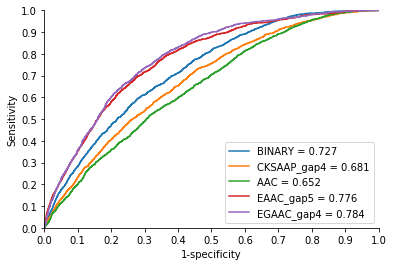

In [43]:
# 去除上 右 边框
# RF-ALL ROC图
# 从文件夹读取ROC01result文本文档，生成ROC图像

q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
q2=[0.726715,0.68148,0.652057,0.775669,0.783727]
q3=[0.0159881,0.0124008,0.0106508,0.0208112,0.0205859]
j=0
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in q:
    
    data = pd.read_csv('C:/Users/Crow/Desktop/new_result/ind_result/result/29_kfold_'+str(i)+'_result_ROC01_result.txt',sep='\t')
     
    
    #plt.title('ROC')
    plt.plot(data['x-axie'], data['y-axie'],label='%s'%i + ' = %0.3f'%q2[j])
    plt.legend(loc=0)
    j+=1
    # plt.xticks([x for x in np.arange(0,1.1,0.1)])  
    # plt.yticks([y for y in np.arange(0,1.1,0.1)]) 
    # 只有最终坐标值未达到，坐标极值点才会弯曲向下终结
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.xlabel('1-specificity')
    plt.ylabel('Sensitivity')

plt.savefig('c:/Users/Crow/Desktop/new_result/picture/Ind_RF_ROC_result.pdf',dpi=600)
#plt.close(0)

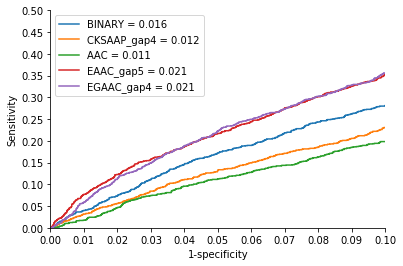

In [42]:
# 去除上 右 边框
# RF-ALL ROC图
# 从文件夹读取ROC01result文本文档，生成ROC图像

q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
q2=[0.726715,0.68148,0.652057,0.775669,0.783727]
q3=[0.0159881,0.0124008,0.0106508,0.0208112,0.0205859]
j=0
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in q:
    
    data = pd.read_csv('C:/Users/Crow/Desktop/new_result/ind_result/result/29_kfold_'+str(i)+'_result_ROC01_result.txt',sep='\t')
    data2 = data[data['x-axie']<=0.1]
    
    #plt.title('ROC')
    plt.plot(data2['x-axie'], data2['y-axie'],label='%s'%i + ' = %0.3f'%q3[j])
    plt.legend(loc=0)
    j+=1
    
    #plt.xticks([x for x in np.arange(0,0.11,0.01)])  
    #plt.yticks([y for y in np.arange(0,0.55,0.05)])  
    plt.xticks(np.arange(0,0.11,0.01))
    plt.yticks(np.arange(0,0.55,0.05))
    
    plt.xlim(0,0.1)
    plt.ylim(0,0.5)
    
    #plt.plot([0,0.1],[0,1],'r--')
    plt.xlabel('1-specificity')
    plt.ylabel('Sensitivity')
    # 调整子图之间距离
    # plt.tight_layout()
    # 调整整幅图像相对位置
    # fig.subplots_adjust(left=0,right=0.99,bottom=0.07,top=0.95,wspace=0.1,hspace=0.1)
plt.savefig('c:/Users/Crow/Desktop/new_result/picture/Ind_RF_ROC01_result.pdf',dpi=600)
plt.close(0)

2.0

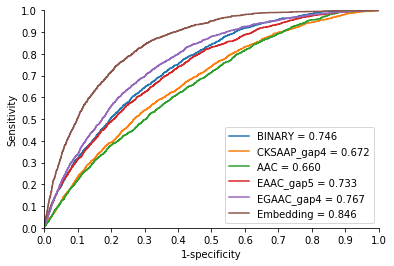

In [41]:
# CNN 十折交叉检验结果绘图
q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4','Embedding']
q2=[0.746142,0.671855,0.660003,0.732724,0.767296,0.845928]
q3=[0.0184706,0.0117919,0.0114428,0.0183031,0.0193919,0.0300941]
j=0
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in q:
    
    data = pd.read_csv('C:/Users/Crow/Desktop/new_result/CNN/ind_result/result/29_kfold_CNN_'+str(i)+'_result_ROC01_result.txt',sep='\t')
     
    
    #plt.title('ROC')
    plt.plot(data['x-axie'], data['y-axie'],label='%s'%i + ' = %0.3f'%q2[j])
    plt.legend(loc=0)
    j+=1
    # plt.xticks([x for x in np.arange(0,1.1,0.1)])  
    # plt.yticks([y for y in np.arange(0,1.1,0.1)]) 
    # 只有最终坐标值未达到，坐标极值点才会弯曲向下终结
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.xlabel('1-specificity')
    plt.ylabel('Sensitivity')

plt.savefig('c:/Users/Crow/Desktop/new_result/picture/Ind_CNN_ROC_result.pdf',dpi=600)

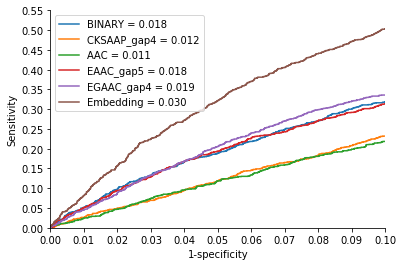

In [40]:
# 去除上 右 边框
# DL-ALL ROC图
# 从文件夹读取ROC01result文本文档，生成ROC图像
# CNN 十折交叉检验结果绘图
q = ['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4','Embedding']
q2=[0.746142,0.671855,0.660003,0.732724,0.767296,0.845928]
q3=[0.0184706,0.0117919,0.0114428,0.0183031,0.0193919,0.0300941]
j=0
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in q:
    
    data = pd.read_csv('C:/Users/Crow/Desktop/new_result/CNN/ind_result/result/29_kfold_CNN_'+str(i)+'_result_ROC01_result.txt',sep='\t')
    data2 = data[data['x-axie']<=0.1]
    
    #plt.title('ROC')
    plt.plot(data2['x-axie'], data2['y-axie'],label='%s'%i + ' = %0.3f'%q3[j])
    plt.legend(loc=0)
    j+=1
    
    #plt.xticks([x for x in np.arange(0,0.11,0.01)])  
    #plt.yticks([y for y in np.arange(0,0.55,0.05)])  
    plt.xticks(np.arange(0,0.11,0.01))
    plt.yticks(np.arange(0,0.60,0.05))
    
    plt.xlim(0,0.1)
    plt.ylim(0,0.55)
    
    #plt.plot([0,0.1],[0,1],'r--')
    plt.xlabel('1-specificity')
    plt.ylabel('Sensitivity')
    # 调整子图之间距离
    # plt.tight_layout()
    # 调整整幅图像相对位置
    # fig.subplots_adjust(left=0,right=0.99,bottom=0.07,top=0.95,wspace=0.1,hspace=0.1)
plt.savefig('c:/Users/Crow/Desktop/new_result/picture/Ind_CNN_ROC01_result.pdf',dpi=600)
plt.close(0)

In [44]:
mpl.artist.getp(fig)

    agg_filter = None
    alpha = None
    animated = False
    axes = [<matplotlib.axes._subplots.AxesSubplot object at ...
    children = [<matplotlib.patches.Rectangle object at 0x000001B...
    clip_box = None
    clip_on = True
    clip_path = None
    constrained_layout = False
    constrained_layout_pads = (0.04167, 0.04167, 0.02, 0.02)
    contains = None
    default_bbox_extra_artists = [<matplotlib.axes._subplots.AxesSubplot object at ...
    dpi = 72.0
    edgecolor = (1.0, 1.0, 1.0, 0.0)
    facecolor = (1.0, 1.0, 1.0, 0.0)
    figheight = 4.0
    figure = None
    figwidth = 6.0
    frameon = True
    gid = None
    in_layout = True
    label = 
    path_effects = []
    picker = None
    rasterized = None
    size_inches = [6. 4.]
    sketch_params = None
    snap = None
    tight_layout = False
    transform = IdentityTransform()
    transformed_clip_path_and_affine = (None, None)
    url = None
    visible = True
    window_extent = TransformedBbox(     Bbox(x0=0.0, y0=

AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=2.163e-04 stat=-5.946e+00
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=2.945e-05 stat=-7.718e+00
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=4.249e-05 stat=-7.367e+00
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=1.435e-04 stat=-6.285e+00
EGAAC_gap4 v.s. Embedding: t-test paired samples, P_val=1.955e-10 stat=-3.082e+01


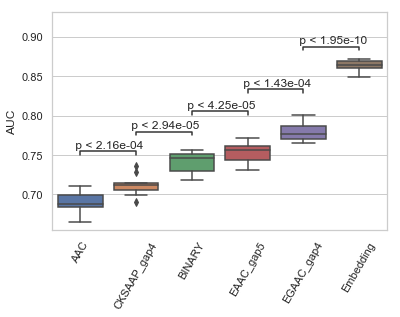

In [70]:
# CNN model boxplot   paired t-test

# CNN 10-fold 后数据
# CNN 画箱线图 和 配对t-test
# CNN 最新十折交叉检验AUC AUC01结果


BINARY = [0.747689,0.727972,0.735877,0.751765,0.757011,0.717918,0.749022,0.754958,0.74513,0.726439]
BINARY_01 = [0.0207467,0.0191619,0.017333,0.0197314,0.0208088,0.0159896,0.0179048,0.0225105,0.0193714,0.0169962]
BINARY_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
BINARY_cutoff = [0.23305900000000002,0.24557199999999998,0.213236,0.22940100000000002,0.230094,0.239806,0.22403499999999998,0.200758,0.246743,0.24060399999999998]
BINARY_acc = [0.8497289972899729,0.8482384823848238,0.8455284552845529,0.8456430410624746,0.8479468762704974,0.8451009621899986,0.8474047973980214,0.851199349505353,0.8476758368342594,0.8494375931698062]
BINARY_sn = [0.35389133627019087,0.3075734157650695,0.3,0.32474964234620884,0.3429811866859624,0.2724458204334365,0.33575581395348836,0.36350148367952523,0.32540861812778604,0.2961165048543689]
BINARY_mcc = [0.22360594140823942,0.18212339893070464,0.1780109190876035,0.20183257272854002,0.2159051062860445,0.15278298897387252,0.20948572381489533,0.2306341442280707,0.19943847557203126,0.1694049993902506]

CKSAAP_gap4 = [0.706052,0.690526,0.715062,0.713427,0.710977,0.699106,0.713093,0.728365,0.736651,0.705442]
CKSAAP_gap4_01 = [0.0169484,0.0169848,0.0179932,0.0176782,0.0155117,0.0163995,0.0190318,0.0206726,0.0184324,0.0173075]
CKSAAP_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
CKSAAP_gap4_cutoff = [0.19909200000000002,0.23067,0.21955100000000002,0.208021,0.223388,0.24653200000000003,0.22803800000000002,0.209202,0.230325,0.24370300000000003] 
CKSAAP_gap4_acc = [0.843089430894309,0.846070460704607,0.846070460704607,0.8441523241631658,0.8438812847269278,0.8456430410624746,0.8468627185255455,0.8490310340154492,0.8465916790893075,0.8502507114785202]
CKSAAP_gap4_sn = [0.28193832599118945,0.28438948995363217,0.30597014925373134,0.3104434907010014,0.2981186685962373,0.2770897832817337,0.32994186046511625,0.34124629080118696,0.3135215453194651,0.3058252427184466]
CKSAAP_gap4_mcc = [0.16414635754809995,0.1628108870292547,0.1829618848879912,0.1896856768555791,0.17895258740343364,0.15686731674561818,0.2047123228051748,0.21244619771482817,0.18966410567140335,0.17725464239046393]

AAC = [0.701042,0.682953,0.68817,0.704925,0.687855,0.676576,0.687853,0.693043,0.710583,0.665366]
AAC_01 = [0.0136223,0.01433,0.0141925,0.0120062,0.0138073,0.0130428,0.0132728,0.0159673,0.0138799,0.0122696]
AAC_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
AAC_cutoff = [0.172198,0.184146,0.180781,0.178989,0.17588,0.178221,0.180703,0.183687,0.18093399999999998,0.183395]
AAC_acc = [0.8388888888888889,0.8415989159891599,0.8405149051490515,0.8369697791028594,0.8392736143108822,0.841441929800786,0.8377828974115734,0.841712969237024,0.8398156931833581,0.8433392058544518]
AAC_sn = [0.23641703377386197,0.23338485316846985,0.24328358208955222,0.23319027181688126,0.24891461649782923,0.22910216718266255,0.23255813953488372,0.26112759643916916,0.23922734026745915,0.22330097087378642]
AAC_mcc = [0.12508779849086726,0.11981879134037865,0.13022755946969644,0.123583542108499,0.13691115566317533,0.11627259935793441,0.12206669364921979,0.1457668289504252,0.12687848622671616,0.10904072421366333]

EAAC_gap5 = [0.752035,0.740742,0.75659,0.757597,0.770505,0.730403,0.755746,0.771228,0.762523,0.739385]
EAAC_gap5_01 = [0.019731,0.0204559,0.0199302,0.0200886,0.0223743,0.0196822,0.0197041,0.0221143,0.0212475,0.0180317]
EAAC_gap5_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EAAC_gap5_cutoff = [0.27279699999999996,0.29164,0.271901,0.297883,0.30606,0.30739299999999997,0.288407,0.269164,0.30035300000000004,0.30391]
EAAC_gap5_acc = [0.851490514905149,0.851490514905149,0.848780487804878,0.8483534354248543,0.8520124678140669,0.8506572706328771,0.8488955142973302,0.8541807833039707,0.851470388941591,0.8509283100691151]
EAAC_gap5_sn = [0.37298091042584436,0.3446676970633694,0.3358208955223881,0.3547925608011445,0.38639652677279307,0.33436532507739936,0.35174418604651164,0.39762611275964393,0.36701337295690933,0.3122977346278317]
EAAC_gap5_mcc = [0.23895067727249336,0.21213345291762625,0.20744617799826018,0.22628134319815776,0.25093005527949985,0.20375546999314514,0.22252600527084254,0.2574726500560449,0.23310397316306256,0.182681284394251]

EGAAC_gap4 = [0.776545,0.777688,0.774448,0.791647,0.783296,0.769771,0.787256,0.76975,0.800217,0.765156]
EGAAC_gap4_01 = [0.0225291,0.0204738,0.0224975,0.0219672,0.0226574,0.0212178,0.0219466,0.0220669,0.0231469,0.0209619]
EGAAC_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EGAAC_gap4_cutoff = [0.241358,0.22298600000000002,0.235171,0.242356,0.23692600000000003,0.24787399999999998,0.21933699999999998,0.23147800000000002,0.239078,0.23155599999999998]
EGAAC_gap4_acc = [0.8524390243902439,0.8525745257452575,0.8524390243902439,0.8518769480959479,0.8502507114785202,0.8529611058408999,0.8503862311966391,0.8532321452771379,0.8547228621764467,0.8533676649952568]
EGAAC_gap4_sn = [0.3832599118942731,0.357032457496136,0.3761194029850746,0.39198855507868385,0.3675832127351664,0.3622291021671827,0.36627906976744184,0.3857566765578635,0.4011887072808321,0.3446601941747573]
EGAAC_gap4_mcc = [0.2471429710737216,0.22199321729198537,0.2398166562933594,0.2562273247180024,0.2358626992843733,0.22576277949046353,0.23451372155149336,0.24835784306876624,0.26040310577584097,0.20799015230989165]

Embedding = [0.864151,0.859165,0.863823,0.867803,0.871516,0.84857,0.864756,0.869022,0.870196,0.855489]
Embedding_01 = [0.0308802,0.0324699,0.0352481,0.034341,0.0318046,0.031575,0.0314986,0.0324783,0.033116,0.0298011]
Embedding_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
Embedding_cutoff = [0.319351,0.342841,0.28714,0.314533,0.302375,0.333415,0.284991,0.347958,0.30733,0.34717]
Embedding_acc = [0.8655826558265582,0.8680216802168021,0.870460704607046,0.8674617156796314,0.8669196368071554,0.8659709987803226,0.8663775579346795,0.8665130776527985,0.8671906762433934,0.8675972353977504]
Embedding_sn = [0.5256975036710719,0.5347758887171561,0.5746268656716418,0.5565092989985694,0.5455861070911722,0.5092879256965944,0.5392441860465116,0.5326409495548962,0.5393759286775631,0.5129449838187702]
Embedding_mcc = [0.35607545571789423,0.35646477003973204,0.3894243368262302,0.38160293662087036,0.37242445683721664,0.33798313508241323,0.36705697999094017,0.35986305475801444,0.364639574177473,0.33521108692062385]

AUC_data ={
    'BINARY':BINARY,
    'CKSAAP_gap4':CKSAAP_gap4,
    'AAC':AAC,
    'EAAC_gap5':EAAC_gap5,
    'EGAAC_gap4':EGAAC_gap4,
    'Embedding':Embedding
} 


AUC01_data ={
    'BINARY':BINARY_01,
    'CKSAAP_gap4':CKSAAP_gap4_01,
    'AAC':AAC_01,
    'EAAC_gap5':EAAC_gap5_01,
    'EGAAC_gap4':EGAAC_gap4_01,
    'Embedding':Embedding_01
}

df = pd.DataFrame(AUC_data)
df_01 = pd.DataFrame(AUC01_data)


columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4','Embedding']
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4','Embedding']



sns.set(style="whitegrid")
ax = sns.boxplot(data=df,order=columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.ylabel("AUC")
add_stat_annotation(ax, data=df, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4"),('EGAAC_gap4','Embedding')],
                    test='t-test_paired', textFormat='full', loc='inside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/AUC_CNN_data_stat_600.png', dpi=600,bbox_inches='tight')

AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=4.585e-06 stat=-9.706e+00
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=6.948e-02 stat=-2.060e+00
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=1.690e-02 stat=-2.925e+00
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=1.551e-03 stat=-4.472e+00
EGAAC_gap4 v.s. Embedding: t-test paired samples, P_val=4.912e-09 stat=-2.144e+01


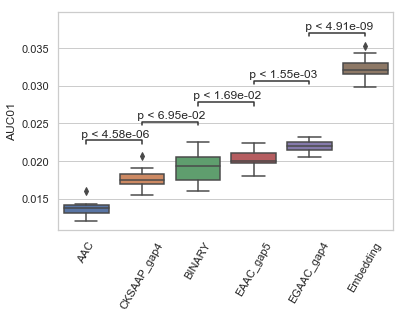

In [72]:
sns.set(style="whitegrid")
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4','Embedding']

ax = sns.boxplot(data=df_01,order=columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


plt.ylabel("AUC01")
add_stat_annotation(ax, data=df_01, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4"),('EGAAC_gap4','Embedding')],
                    test='t-test_paired', textFormat='full', loc='inside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/AUC01_CNN_data_stat_600.png', dpi=600,bbox_inches='tight')


AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=1.644e-06 stat=-1.097e+01
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=1.349e-03 stat=-4.569e+00
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=3.212e-09 stat=-2.250e+01
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=6.986e-02 stat=-2.057e+00


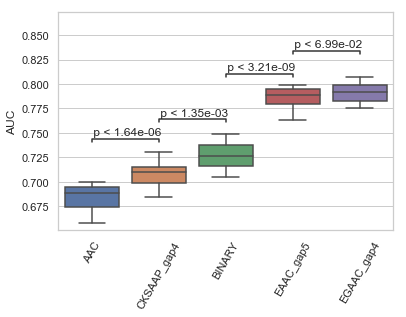

In [76]:
# RF 十折交叉检验数据
# 箱线图绘制
# RF 最新十折交叉检验AUC AUC01结果
BINARY = [0.723361,0.71563,0.711014,0.748953,0.738242,0.704521,0.735801,0.743376,0.729422,0.717307]
BINARY_01 = [0.0139995,0.0195967,0.015495,0.0191304,0.0192827,0.0153877,0.0177918,0.0167652,0.0181078,0.0150561]
BINARY_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
BINARY_cutoff = [0.10736500000000002,0.107744,0.107492,0.106476,0.106928,0.10793299999999999,0.106522,0.10758399999999999,0.10756099999999999,0.10831600000000001]
BINARY_acc = [0.8402439024390244,0.848780487804878,0.843089430894309,0.8455075213443556,0.8471337579617835,0.8446944030356417,0.8465916790893075,0.8448299227537607,0.8464561593711885,0.8482179157067353]
BINARY_sn = [0.2511013215859031,0.31530139103554866,0.2716417910447761,0.32331902718168815,0.3342981186685962,0.26625386996904027,0.32703488372093026,0.2952522255192878,0.31054977711738485,0.2815533980582524]
BINARY_mcc = [0.1378174665954612,0.18820730574303624,0.1544502977180864,0.20064547692164236,0.2087902787621476,0.14780951276609083,0.2023192302120741,0.17457851089251,0.18743410207669997,0.15754574188832518]

CKSAAP_gap4 = [0.708074,0.68444,0.711581,0.716382,0.71162,0.696588,0.704422,0.723463,0.730921,0.687607]
CKSAAP_gap4_01 = [0.0168178,0.0147625,0.0179792,0.0162938,0.0162046,0.0166559,0.0171903,0.0186685,0.0183134,0.014746]
CKSAAP_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
CKSAAP_gap4_cutoff = [0.102931,0.104949,0.10365799999999999,0.102807,0.102979,0.10424100000000001,0.10338,0.103492,0.103049,0.105053]
CKSAAP_gap4_acc = [0.8439024390243902,0.8422764227642277,0.8451219512195122,0.8427971269819758,0.8423905678276189,0.8456430410624746,0.8444233635994037,0.8465916790893075,0.8479468762704974,0.8459140804987125]
CKSAAP_gap4_sn = [0.2907488986784141,0.23956723338485317,0.2955223880597015,0.296137339055794,0.28364688856729375,0.2786377708978328,0.30377906976744184,0.31305637982195844,0.32689450222882616,0.2524271844660194]
CKSAAP_gap4_mcc = [0.1715719436291676,0.12530473174324425,0.17428556493172787,0.17766128760700367,0.16650965930535058,0.1579443580324863,0.18301800588800665,0.18958983875191746,0.20088453111592813,0.1337120650968097]

AAC = [0.690762,0.668639,0.696056,0.692778,0.680706,0.672314,0.685876,0.699649,0.695781,0.658347]
AAC_01 = [0.0130995,0.012225,0.0153707,0.0125776,0.0135578,0.0125106,0.0142182,0.0141296,0.0132737,0.0130869]
AAC_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
AAC_cutoff = [0.144285,0.148843,0.145643,0.14548599999999998,0.144091,0.14961,0.147279,0.14779,0.144724,0.148042]
AAC_acc = [0.8387533875338753,0.8394308943089431,0.8426829268292683,0.8377828974115734,0.8394091340290012,0.8399512129014771,0.8383249762840493,0.8403577720558342,0.8403577720558342,0.8444233635994037]
AAC_sn = [0.23348017621145375,0.20865533230293662,0.26865671641791045,0.24177396280400573,0.2503617945007236,0.21362229102167182,0.2369186046511628,0.24480712166172106,0.2436849925705795,0.23624595469255663]
AAC_mcc = [0.12272818341846888,0.09845348423044477,0.15170999284608938,0.13112636830577576,0.13816753546755267,0.10271346564738286,0.126086474483455,0.13196289572411313,0.1309365137493847,0.11997257084925625]

EAAC_gap5 = [0.781925,0.778667,0.785795,0.799003,0.797184,0.770403,0.79413,0.795108,0.792157,0.763667]
EAAC_gap5_01 = [0.022627,0.0243358,0.0223781,0.0227487,0.0237099,0.0200422,0.0224273,0.0218883,0.022433,0.0206807]
EAAC_gap5_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EAAC_gap5_cutoff = [0.131806,0.13234200000000002,0.13128499999999999,0.130776,0.131805,0.133467,0.130217,0.131625,0.13193,0.133372]
EAAC_gap5_acc = [0.8537940379403794,0.8573170731707317,0.8518970189701897,0.851199349505353,0.8528255861227808,0.8526900664046618,0.8535031847133758,0.8545873424583277,0.8548583818945656,0.8552649410489226]
EAAC_gap5_sn = [0.3964757709251101,0.4126738794435858,0.3701492537313433,0.38483547925608014,0.39363241678726485,0.35758513931888547,0.4011627906976744,0.4020771513353116,0.40416047548291234,0.3656957928802589]
EAAC_gap5_mcc = [0.25785243854699164,0.2652791227001109,0.23506870099547822,0.25051904513951195,0.25692910897687726,0.22231536966023605,0.26206327617763214,0.26096611240448203,0.26248386530907786,0.22470790020789147]

EGAAC_gap4 = [0.783741,0.789916,0.793433,0.802873,0.796848,0.780132,0.799697,0.781684,0.807662,0.775109]
EGAAC_gap4_01 = [0.0208239,0.0223318,0.0229944,0.0223309,0.0243657,0.021223,0.0230216,0.0197138,0.023986,0.02083]
EGAAC_gap4_sp = [0.900134,0.9000450000000001,0.9,0.9,0.90012,0.9000450000000001,0.900015,0.900075,0.9000889999999999,0.900015]
EGAAC_gap4_cutoff =[0.173765,0.17643399999999998,0.17324900000000001,0.173405,0.17344400000000001,0.17635699999999999,0.171612,0.175482,0.173024,0.177122]
EGAAC_gap4_acc = [0.8510840108401084,0.8547425474254743,0.8543360433604336,0.851470388941591,0.8536387044314948,0.8533676649952568,0.8535031847133758,0.8507927903509961,0.8549939016126846,0.8551294213308036]
EGAAC_gap4_sn = [0.3671071953010279,0.38176197836166925,0.3970149253731343,0.38626609442060084,0.402315484804631,0.3668730650154799,0.3997093023255814,0.36053412462908013,0.40416047548291234,0.3640776699029126]
EGAAC_gap4_mcc = [0.2344877827252809,0.24150643658604962,0.25630853837649004,0.2519089674802281,0.2638016928082518,0.22943440373372828,0.2611645651776675,0.22801583232366412,0.26273160982071003,0.22344613203687844]
AUC_data ={
    'BINARY':BINARY,
    'CKSAAP_gap4':CKSAAP_gap4,
    'AAC':AAC,
    'EAAC_gap5':EAAC_gap5,
    'EGAAC_gap4':EGAAC_gap4
} 


AUC01_data ={
    'BINARY':BINARY_01,
    'CKSAAP_gap4':CKSAAP_gap4_01,
    'AAC':AAC_01,
    'EAAC_gap5':EAAC_gap5_01,
    'EGAAC_gap4':EGAAC_gap4_01
}

df = pd.DataFrame(AUC_data)
df_01 = pd.DataFrame(AUC01_data)


columns=['BINARY','CKSAAP_gap4','AAC','EAAC_gap5','EGAAC_gap4']
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4']


sns.set(style="whitegrid")
ax = sns.boxplot(data=df,  order=columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.ylabel("AUC")
add_stat_annotation(ax, data=df, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4")],
                    test='t-test_paired', textFormat='full', loc='inside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/AUC_RF_data_stat_600.png', dpi=600,bbox_inches='tight')

AAC v.s. CKSAAP_gap4: t-test paired samples, P_val=3.193e-06 stat=-1.014e+01
CKSAAP_gap4 v.s. BINARY: t-test paired samples, P_val=7.231e-01 stat=-3.656e-01
BINARY v.s. EAAC_gap5: t-test paired samples, P_val=1.248e-06 stat=-1.134e+01
EAAC_gap5 v.s. EGAAC_gap4: t-test paired samples, P_val=7.121e-01 stat=3.809e-01


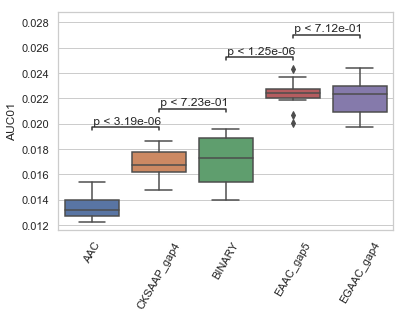

In [77]:
columns=['AAC','CKSAAP_gap4','BINARY','EAAC_gap5','EGAAC_gap4']

sns.set(style="whitegrid")
ax = sns.boxplot(data=df_01,order=columns)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.ylabel("AUC01")
add_stat_annotation(ax, data=df_01, order=columns,
                    boxPairList=[("AAC", "CKSAAP_gap4"), ("CKSAAP_gap4", "BINARY"), ("BINARY", "EAAC_gap5"),("EAAC_gap5","EGAAC_gap4")],
                    test='t-test_paired', textFormat='full', loc='inside', verbose=2)
plt.savefig('C:/Users/Crow/Desktop/AUC01_RF_data_stat_600.png', dpi=600,bbox_inches='tight')

In [28]:
RF_datasize_AUC = [0.7070986752304644,0.7480501787615261,0.7699255091632049,0.7841666582180875,0.791109499999999]
RF_datasize_AUC01 = [0.014056359,0.019715319999999998,0.02097102,0.021882759999999998,0.02216211]

CNN_datasize_AUC = [0.697676,0.7714705894562085,0.811883392333894,0.8401423704633986,0.863449099999999]
CNN_datasize_AUC01 = [0.017510147,0.022002960000000002,0.024321950000000002,0.028085879999999997,0.03232128]

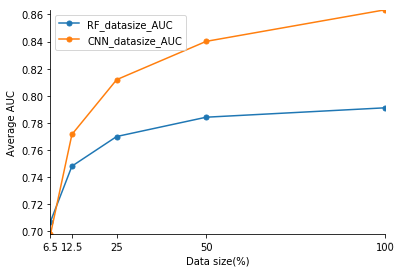

In [51]:
#plt.plot(x, y1, 'bo-')
#pl.xlim(-1, 11)  # 限定横轴的范围
#pl.ylim(-1, 110)  # 限定纵轴的范围
y = [6.5,12.5,25,50,100]
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(y,RF_datasize_AUC, marker='.',ms=10,label='RF_datasize_AUC')
plt.plot(y,CNN_datasize_AUC, marker='.',ms=10,label='CNN_datasize_AUC')
plt.legend(loc=0)# 让图例生效
plt.xticks(y, y, rotation=1)
 
plt.margins(0)
plt.subplots_adjust(bottom=0.10)
plt.xlabel('Data size(%)') #X轴标签
plt.ylabel('Average AUC')
plt.savefig('c:/Users/Crow/Desktop/Datasise_AUC_result.pdf',dpi=600)


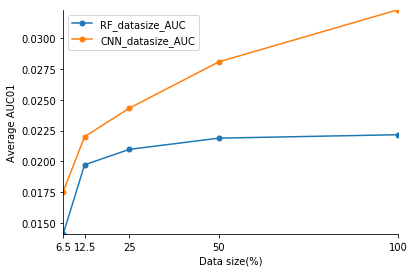

In [52]:
y = [6.5,12.5,25,50,100]
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(y,RF_datasize_AUC01, marker='.', ms=10,label='RF_datasize_AUC')
plt.plot(y,CNN_datasize_AUC01, marker='.', ms=10,label='CNN_datasize_AUC')
plt.legend(loc=0)  # 让图例生效
plt.xticks(y, y, rotation=1)
 
plt.margins(0)
plt.subplots_adjust(bottom=0.10)
plt.xlabel('Data size(%)') #X轴标签
plt.ylabel('Average AUC01')
plt.savefig('C:/Users/Crow/Desktop/Datasise_AUC01_result.pdf',dpi=600)


In [33]:
import sys
path = 'C:/Users/Crow/Desktop/jupyter/PlotNeuralNet-master/'
sys.path.append(path)
from pycore.tikzeng import *

# defined your arch
arch = [
    to_head( 'C:/Users/Crow/Desktop/jupyter/PlotNeuralNet-master/' ),
    to_cor(),
    to_begin(),
    
    to_Conv("conv1", 128, 8, offset="(0,0,0)", to="(0,0,0)", height=64, depth=64, width=1),
    to_Pool("pool1", offset="(0,0,0)", to="(conv1-east)"),
    
    #to_skip( of='pool1', to='conv2', pos=1.25),
    
    to_Conv("conv2", 128, 8, offset="(1,0,0)", to="(pool1-east)", height=64, depth=32, width=1 ),
    to_connection( "pool1", "conv2"), 
    to_Pool("pool2", offset="(0,0,0)", to="(conv2-east)", height=64, depth=32, width=1),
    
    #to_skip( of='pool2', to='conv3', pos=1.25),
    
    to_Conv("conv3", 128, 8, offset="(1,0,0)", to="(pool1-east)", height=64, depth=16, width=1 ),
    to_connection( "pool2", "conv3"), 
    to_Pool("pool3", offset="(0,0,0)", to="(conv2-east)", height=64, depth=16, width=1),
    
    #to_skip( of='pool3', to='soft1', pos=1.25),
    
    to_SoftMax("soft1", 2 ,"(3,0,0)", "(pool1-east)", caption="SOFT"  ),
    to_connection("pool3", "soft1"),    
    to_end()
    ]


#amefile = str(sys.argv[0]).split('.')[0]
to_generate(arch,  'C:/Users/Crow/Desktop/2.tex' )




\documentclass[border=8pt, multi, tikz]{standalone} 
\usepackage{import}
\subimport{C:/Users/Crow/Desktop/jupyter/PlotNeuralNet-master/layers/}{init}
\usetikzlibrary{positioning}
\usetikzlibrary{3d} %for including external image 


\def\ConvColor{rgb:yellow,5;red,2.5;white,5}
\def\ConvReluColor{rgb:yellow,5;red,5;white,5}
\def\PoolColor{rgb:red,1;black,0.3}
\def\UnpoolColor{rgb:blue,2;green,1;black,0.3}
\def\FcColor{rgb:blue,5;red,2.5;white,5}
\def\FcReluColor{rgb:blue,5;red,5;white,4}
\def\SoftmaxColor{rgb:magenta,5;black,7}   


\newcommand{\copymidarrow}{\tikz \draw[-Stealth,line width=0.8mm,draw={rgb:blue,4;red,1;green,1;black,3}] (-0.3,0) -- ++(0.3,0);}

\begin{document}
\begin{tikzpicture}
\tikzstyle{connection}=[ultra thick,every node/.style={sloped,allow upside down},draw=\edgecolor,opacity=0.7]
\tikzstyle{copyconnection}=[ultra thick,every node/.style={sloped,allow upside down},draw={rgb:blue,4;red,1;green,1;black,3},opacity=0.7]


\pic[shift={(0,0,0)}] at (0,0,0) 
    {Box={

In [18]:
to_ConvConvRelu()

'C:\\Users\\Crow\\AppData\\Local\\conda\\conda\\envs\\deeplearning\\lib\\site-packages\\ipykernel_launcher'

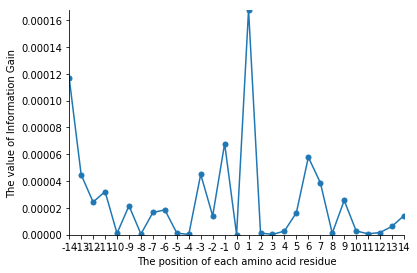

In [19]:
# 信息增益绘图
x = range(-14,15,1)
y = [0.00011678582042096153,
 4.470653072735642e-05,
 2.424300007114466e-05,
 3.208072312288479e-05,
 8.787170828195023e-07,
 2.1459821977598548e-05,
 3.9010590824339886e-07,
 1.644458098792878e-05,
 1.8417621698463282e-05,
 1.0611318503883638e-06,
 4.723680036011757e-08,
 4.4910525506702825e-05,
 1.3887856658845177e-05,
 6.79289420492668e-05,
 0.0,
 0.00016778730651567653,
 1.138320820159855e-06,
 7.321542405680503e-08,
 2.5674838536327016e-06,
 1.630990075751626e-05,
 5.773909455797366e-05,
 3.8804535266112605e-05,
 9.413455681062111e-07,
 2.544223705863713e-05,
 2.654822987779859e-06,
 5.143668208584806e-07,
 1.5044541673003842e-06,
 6.109937042420022e-06,
 1.4191019115650239e-05]
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(x,y, marker='.', ms=10,label='')

plt.xticks(x, x, rotation=1)
 
plt.margins(0)
plt.subplots_adjust(bottom=0.10)
plt.xlabel('The position of each amino acid residue') #X轴标签 
plt.ylabel('The value of Information Gain')
plt.savefig('C:/Users/Crow/Desktop/InformationGain.pdf',dpi=600)
